In [1]:
import warnings
warnings.filterwarnings("ignore") # suppress warnings

In [2]:
import os
import sys
import h5py
import laspy
import pyproj
import folium
import datetime 
import rasterio
import numpy as np
import pandas as pd
import richdem as rd
import rasterio.mask
import rasterio.merge
import seaborn as sns
import rasterio.features
import geopandas as gpd
from pathlib import Path
import contextily as ctx  # For adding a basemap
import statsmodels.api as sm
from rasterio.mask import mask
from rasterio.plot import show
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from pyproj import Transformer, CRS
from rasterstats import zonal_stats 
from rasterstats import point_query
from rasterio.warp import reproject
import matplotlib.patches as patches
from rasterio.enums import Resampling
from scipy.interpolate import griddata
from shapely.geometry import Point, box
from rasterio.plot import plotting_extent
from geoviews import opts, tile_sources as gvts
from matplotlib.patches import Circle, Polygon
from matplotlib.collections import PatchCollection
from shapely.geometry import Polygon as ShpPolygon
from shapely.ops import transform as shp_transform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

plt.style.use("~/geoscience/carbon_estimation/MNRAS.mplstyle")
%matplotlib inline

In [3]:
function_path = os.path.expanduser("~/geoscience/carbon_estimation/code/functions")
sys.path.append(function_path)

# Check the default PROJ data directory
print(pyproj.datadir.get_data_dir())

/bsuscratch/tnde/miniforge3/envs/veg_height/share/proj


In [4]:
dtm_path = "/bsuhome/tnde/scratch/carbon_estimation/airborne_lidar/las_dtm/USGS_LPC_ID_SouthernID_2018_D19_11TNH175700.tif"
dtm = rd.LoadGDAL(dtm_path)
slope = rd.TerrainAttribute(dtm, attrib='slope_degrees')
slope_raster_path = "/bsuhome/tnde/scratch/carbon_estimation/airborne_lidar/slope_rasters/slope_USGS_LPC_ID_SouthernID_2018_D19_11TNH175700.tif"
rd.SaveGDAL(slope_raster_path, slope)


A Slope calculation (degrees)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.104313======================= ] (99% - 0.0s - 1 threads)


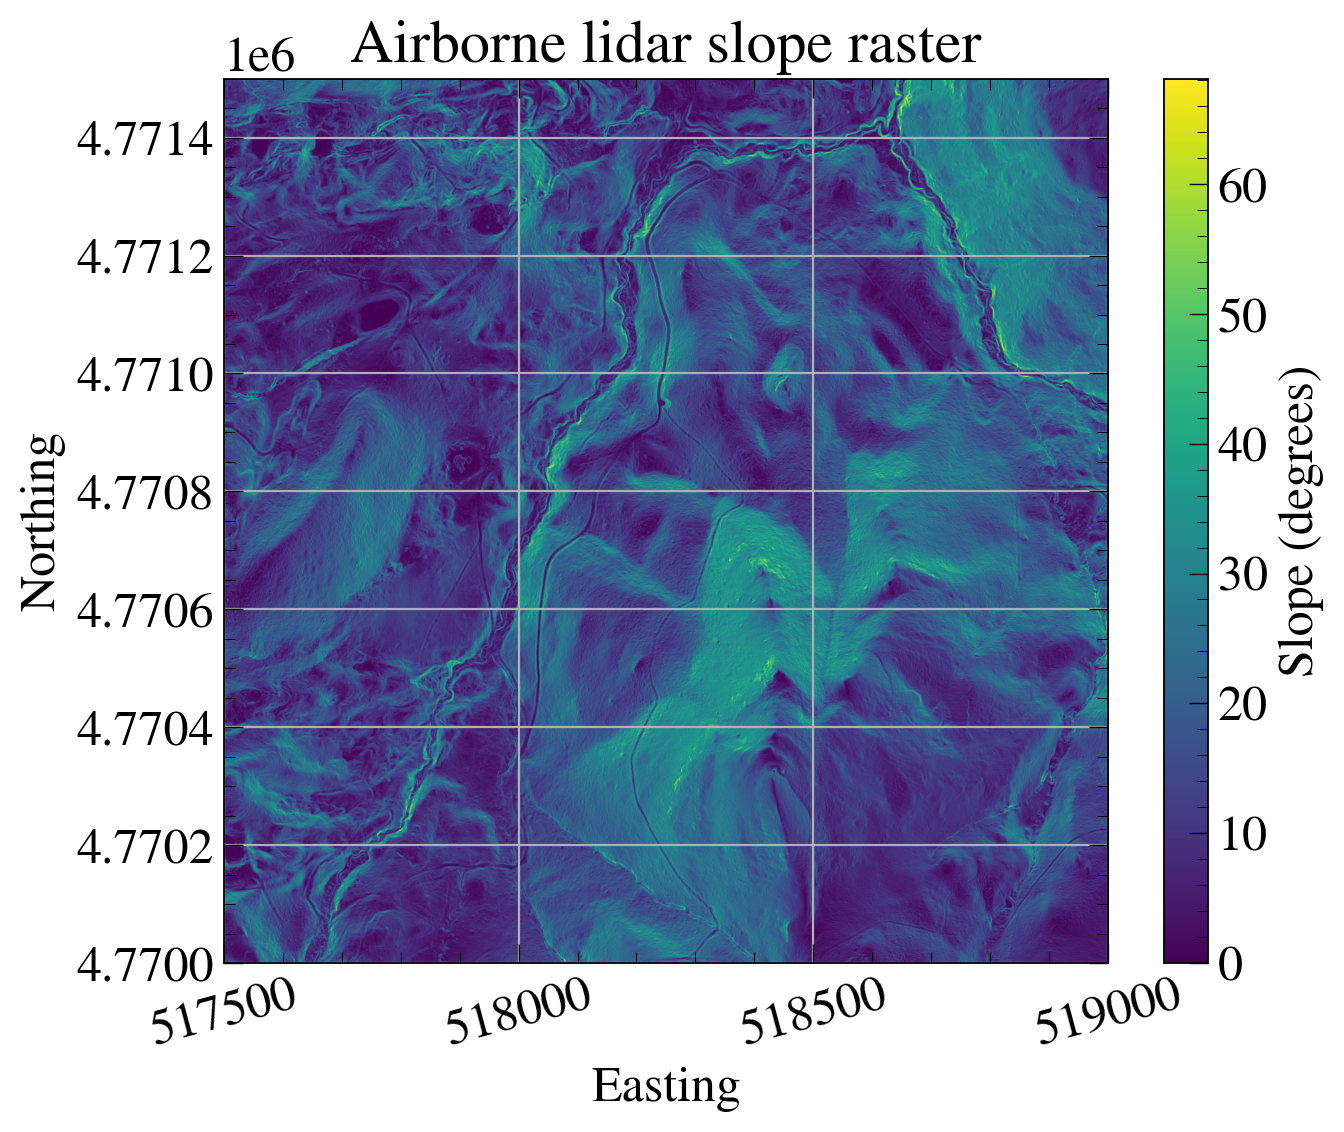

In [5]:
with rasterio.open(slope_raster_path) as ds:
    arr = ds.read(1, masked=True)  # nodata -> mask
    extent = plotting_extent(ds)

plt.figure(figsize=(8,6))
im = plt.imshow(arr, extent=extent, origin="upper")
plt.tick_params(axis='x', rotation=15)
plt.title("Airborne lidar slope raster")
plt.xlabel("Easting"); plt.ylabel("Northing")
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label("Slope (degrees)")
plt.tight_layout(); plt.show()

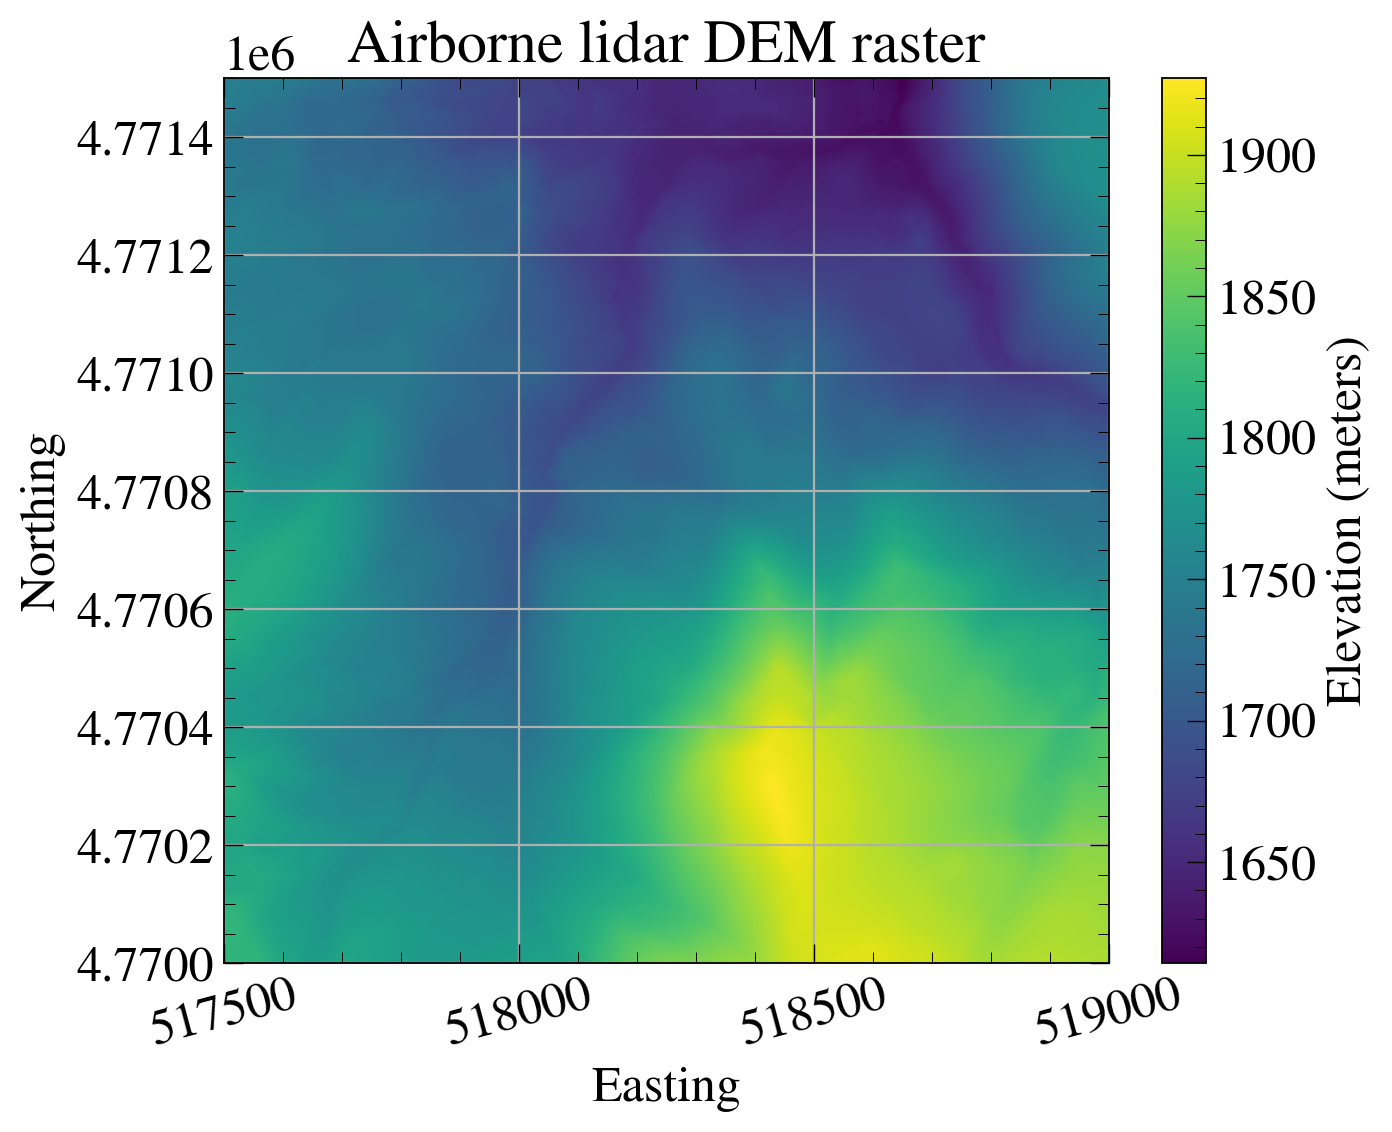

In [6]:
with rasterio.open(dtm_path) as ds:
    arr = ds.read(1, masked=True)  # nodata -> mask
    extent = plotting_extent(ds)

plt.figure(figsize=(8,6))
im = plt.imshow(arr, extent=extent, origin="upper")
plt.tick_params(axis='x', rotation=15)
plt.title("Airborne lidar DEM raster")
plt.xlabel("Easting"); plt.ylabel("Northing")
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label("Elevation (meters)")
plt.tight_layout(); plt.show()

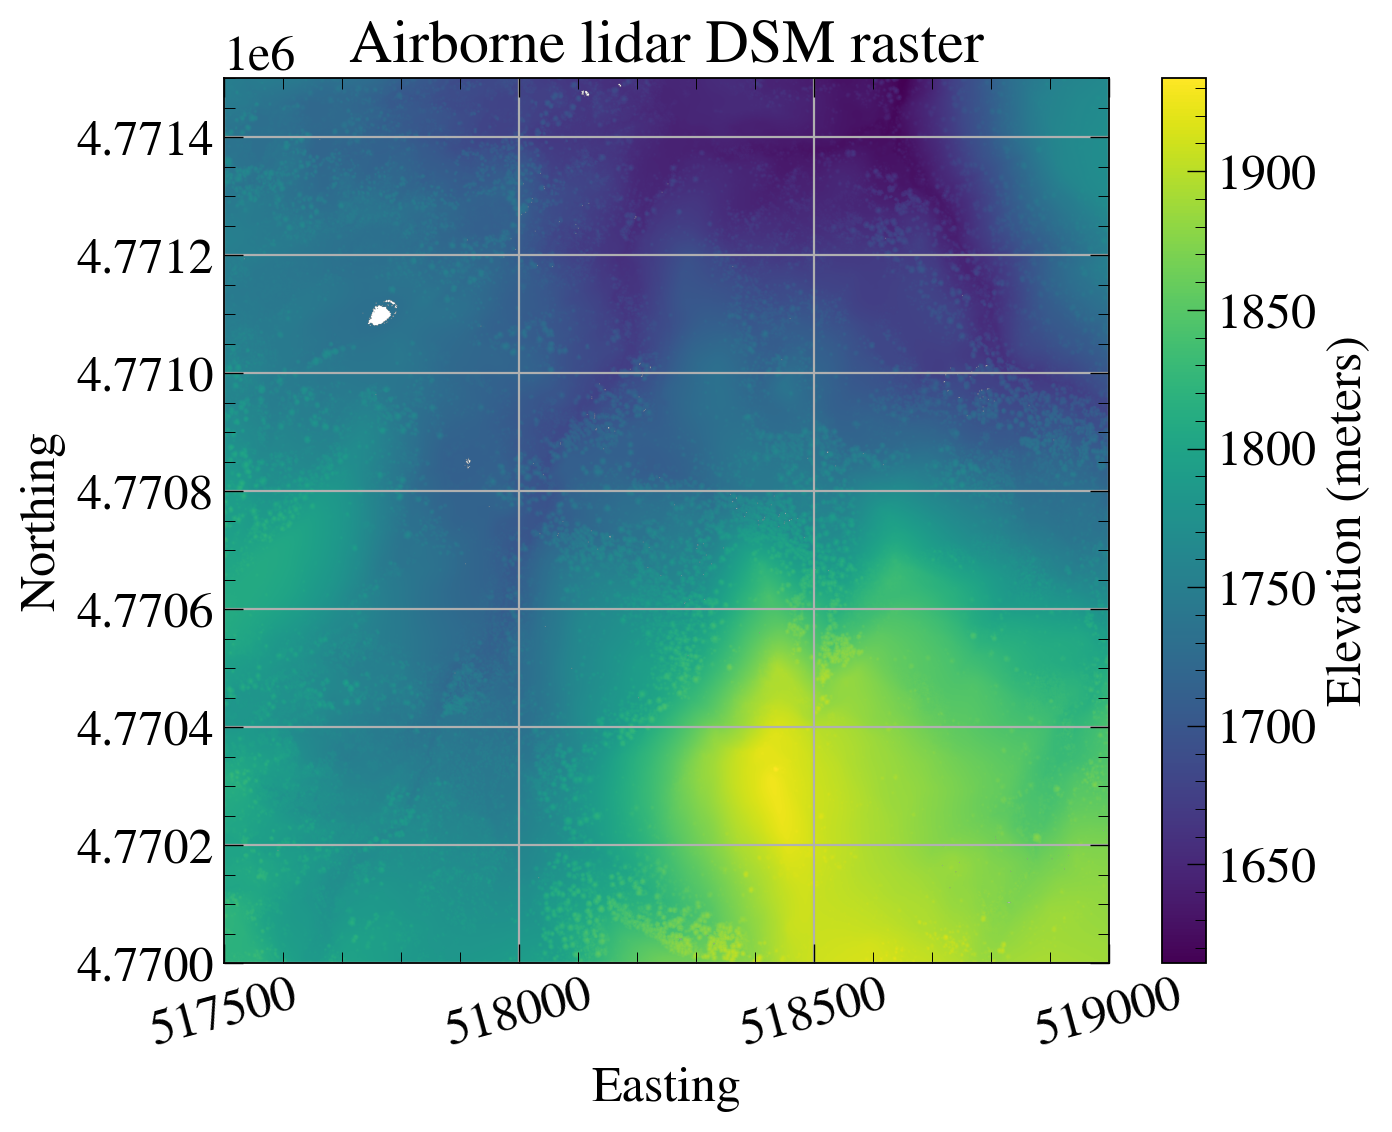

In [7]:
dsm_path = "/bsuhome/tnde/scratch/carbon_estimation/airborne_lidar/lasgrid_dsm/USGS_LPC_ID_SouthernID_2018_D19_11TNH175700.tif"
with rasterio.open(dsm_path) as ds:
    arr = ds.read(1, masked=True)  # nodata -> mask
    extent = plotting_extent(ds)

plt.figure(figsize=(8,6))
im = plt.imshow(arr, extent=extent, origin="upper")
plt.tick_params(axis='x', rotation=15)
plt.title("Airborne lidar DSM raster")
plt.xlabel("Easting"); plt.ylabel("Northing")
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label("Elevation (meters)")
plt.tight_layout(); plt.show()

## Loading ICESat-2 Data

In [8]:
from helper_functions import load_icesat2_data
projected_crs = "epsg:6340" 
icesat2_file = "icesat2_ml_final.geojson"
icesat2_dir = "/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/ml_data/"
atl08 = icesat2_dir+f'{icesat2_file}'
atl08

'/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/ml_data/icesat2_ml_final.geojson'

In [9]:
%%time
icesat2_gdf_atl08 = load_icesat2_data(atl08, "ATL08", process = False)
icesat2_gdf_atl08 = icesat2_gdf_atl08[icesat2_gdf_atl08["gnd_ph_count"] != 0]
icesat2_gdf_atl08 = icesat2_gdf_atl08[icesat2_gdf_atl08["h_mean_canopy"] <= 15]
icesat2_gdf_atl08 = icesat2_gdf_atl08.rename(columns={"elevation_NAVD88_icesat2_from_crs": "Elevation"})
print(f"Length of data: {len(icesat2_gdf_atl08)}")
print(icesat2_gdf_atl08.crs, "\n")
icesat2_gdf_atl08.crs

Length of data: 32814
EPSG:6340 

CPU times: user 2.78 s, sys: 45.3 ms, total: 2.83 s
Wall time: 2.86 s


<Projected CRS: EPSG:6340>
Name: NAD83(2011) / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United States (USA) - between 120°W and 114°W onshore and offshore - California, Idaho, Nevada, Oregon, Washington.
- bounds: (-120.0, 30.88, -114.0, 49.01)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## Loading GEDI Data

In [10]:
drop_cols = ["shot_number", "Latitude_l2a", "Longitude_l2a", 
             "rh_85", "rh_90", "rh_98", "rh_99", "GEDI02_A_slope_ratio_utm", 
             "GEDI02_A_slope_rise_run", "cover_z_10", "cover_z_15", "cover_z_20", 
             "cover_z_25", "cover_z_27", "cover_z_28", "pai_z_10", "pai_z_15", 
             "pai_z_20", "pai_z_25", "pai_z_27", "pai_z_28", "pavd_z_10", 
             "pavd_z_15", "pavd_z_20", "pavd_z_25", "pavd_z_27", "pavd_z_28", "rh100"]

In [11]:
target_col = "rh_80" # "rh_100"
gedi_dir = "/bsuhome/tnde/scratch/carbon_estimation/data/gedi_data/gedi_finder/ml_data/"
gedi_file = "gedi_ml2.geojson"
gedi_data = gpd.read_file(os.path.join(gedi_dir, gedi_file))
bbox_gedi = np.min(gedi_data["Easting_l2a"]), np.min(gedi_data["Northing_l2a"]), np.max(gedi_data["Easting_l2a"]), np.max(gedi_data["Northing_l2a"])
# x_min, y_min, x_max, y_max = list(bbox_gedi)
gedi_data = gedi_data.drop(drop_cols, axis = 1)
gedi_data = gedi_data[gedi_data["fhd_normal"] != -9999.000000]
gedi_data = gedi_data[gedi_data[target_col] <= 15]
gedi_data.head()

date  BEAM_l2a  quality_flag  num_detectedmodes  rh_80  \
0 2019-07-23 02:29:57  BEAM1011             1                  1   1.08   
1 2019-07-23 02:29:57  BEAM1011             1                  1   0.97   
2 2019-07-23 02:29:57  BEAM1011             1                  1   1.12   
3 2019-07-23 02:29:57  BEAM1011             1                  1   0.93   
4 2019-07-23 02:29:57  BEAM1011             1                  1   0.89   

   rh_95  rh_100  sensitivity  solar_elevation    Easting_l2a  Northing_l2a  \
0   2.21    4.04     0.976120         1.137563  513688.964915  4.795170e+06   
1   1.94    3.63     0.975038         1.137287  513736.570004  4.795201e+06   
2   2.43    4.90     0.976903         1.137010  513784.205063  4.795233e+06   
3   1.91    3.59     0.971373         1.136734  513831.832065  4.795264e+06   
4   1.83    3.37     0.973743         1.136458  513879.447137  4.795295e+06   

   elevation_NAVD88_gedi_from_crs_l2a  GEDI02_A_slope_degrees_utm  \
0                         1815.427281                    0.996506   
1                         1815.428389                    0.001113   
2                         1814.398598                   -1.034706   
3                         1813.271707                   -1.132363   
4                         1813.272818                    0.001117   

   rx_sample_count  cover_z_29  fhd_normal  pai_z_29  pavd_z_29  \
0            755.0         0.0    1.417535      -0.0       -0.0   
1            749.0         0.0    1.340707      -0.0       -0.0   
2            766.0         0.0    1.658798      -0.0       -0.0   
3            745.0         0.0    1.269725      -0.0       -0.0   
4            745.0         0.0    0.790818      -0.0       -0.0   

                         geometry  
0  POINT (513688.965 4795169.966)  
1   POINT (513736.57 4795201.316)  
2  POINT (513784.205 4795232.651)  
3  POINT (513831.832 4795263.988)  
4  POINT (513879.447 4795295.327)

## Workflow

In [ ]:
# =========================
# CONFIG
# =========================
# Input tile directories: GeoTIFF tiles
DTM_DIR = Path("/bsuhome/tnde/scratch/carbon_estimation/airborne_lidar/las_dtm/")    # DTM
DSM_DIR = Path("/bsuhome/tnde/scratch/carbon_estimation/airborne_lidar/lasgrid_dsm/")    # DSM

# Optionally, set CHM_DIR and skip DSM
CHM_DIR = None  # e.g., Path("/path/to/chm_tiles") or None

# Outputs
OUT_DIR = Path(Path("/bsuhome/tnde/scratch/carbon_estimation/airborne_lidar/mosaics/") )
OUT_DIR.mkdir(parents=True, exist_ok=True)

DTM_MOSAIC = OUT_DIR / "lidar_dtm_mosaic.tif"
DSM_MOSAIC = OUT_DIR / "lidar_dsm_mosaic.tif"
CHM_MOSAIC = OUT_DIR / "lidar_chm_mosaic.tif"
SLOPE_MOSAIC = OUT_DIR / "lidar_slope_deg.tif"

# GEDI and ATL08 vectors
GEDI_VECT = Path("/bsuhome/tnde/scratch/carbon_estimation/data/gedi_data/gedi_finder/ml_data/gedi_ml2.geojson")
ATL08_VECT = Path("/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/ml_data/icesat2_ml_final.geojson")

# Column names for vegetation height in the vector attribute tables
gedi_height_col = "rh_80"          # or "rh_100"
atl08_height_col = "h_mean_canopy"     # or "h_max_canopy"

# Approximate footprint buffers (meters)
gedi_buffer_m = 12.5

# CRS to use for all rasters and vectors (projected! so the buffers are in meters)
# If DTM tiles already have a projected CRS, you can leave this as None to keep native.
TARGET_CRS = None  # e.g., "EPSG:6340" or None

# -------------------------
# Utility: find rasters
# -------------------------
def list_tifs(folder: Path):
    return sorted([str(p) for p in folder.glob("*.tif")])

# --------------------------------
# Mosaic tiles into one GeoTIFF
# --------------------------------
def mosaic_tiles(tif_list, dst_path, target_crs=None, dst_dtype="float32", resampling=Resampling.bilinear):
    if len(tif_list) == 0:
        raise FileNotFoundError(f"No GeoTIFFs found to mosaic for {dst_path}")
    srcs = [rasterio.open(p) for p in tif_list]

    # Reproject on the fly if target_crs is requested and differs
    if target_crs is not None:
        target_crs = CRS.from_user_input(target_crs)

    # Merge (note: rasterio.merge will reproject if 'precision' and 'res' differ. We will keep simple merge.)
    mosaic, out_transform = rasterio.merge.merge(srcs, resampling=resampling)
    out_meta = srcs[0].meta.copy()
    out_meta.update({
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_transform,
        "dtype": dst_dtype
    })

    # Write temp
    with rasterio.open(dst_path, "w", **out_meta) as dst:
        dst.write(mosaic.astype(dst_dtype))

    # Optionally, reproject to target_crs
    if target_crs is not None and out_meta.get("crs") and CRS.from_user_input(out_meta["crs"]) != target_crs:
        reproj_path = dst_path.with_name(dst_path.stem + f"_{target_crs.to_authority()[0]}{target_crs.to_authority()[1]}.tif")
        reproject_to(dst_path, reproj_path, target_crs)
        os.replace(reproj_path, dst_path)

    for s in srcs:
        s.close()

    return str(dst_path)

# ---------------------------
# Reproject a raster to a CRS
# ---------------------------
def reproject_to(src_path, dst_path, target_crs):
    with rasterio.open(src_path) as src:
        transform, width, height = rasterio.warp.calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update({
            "crs": target_crs,
            "transform": transform,
            "width": width,
            "height": height
        })
        with rasterio.open(dst_path, "w", **kwargs) as dst:
            for i in range(1, src.count + 1):
                rasterio.warp.reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.bilinear
                )
    return str(dst_path)

# ----------------------------------------
# Compute CHM mosaic as DSM - DTM 
# ----------------------------------------
def compute_chm(dsm_path, dtm_path, out_path, nodata_out=-9999, max_height=15):
    with rasterio.open(dsm_path) as dsm, rasterio.open(dtm_path) as dtm:
        if dsm.crs != dtm.crs:
            raise ValueError("DSM and DTM must share the same CRS. Reproject first.")
        if (dsm.transform != dtm.transform) or (dsm.width != dtm.width) or (dsm.height != dtm.height):
            raise ValueError("DSM and DTM grids must be aligned. Resample/reproject one to the other.")

        dsm_arr = dsm.read(1).astype("float32")
        dtm_arr = dtm.read(1).astype("float32")

        # Build valid mask from nodata or non-finite
        dsm_nd = dsm.nodata
        dtm_nd = dtm.nodata
        valid = np.isfinite(dsm_arr) & np.isfinite(dtm_arr)
        if dsm_nd is not None:
            valid &= dsm_arr != dsm_nd
        if dtm_nd is not None:
            valid &= dtm_arr != dtm_nd

        chm = np.full_like(dtm_arr, np.float32(nodata_out))
        chm[valid] = dsm_arr[valid] - dtm_arr[valid]

        # Clean up: no negatives, and cap improbable outliers
        chm[valid & (chm < 0)] = 0.0
        chm[valid & (chm > max_height)] = max_height  # optional but helpful for plotting

        meta = dtm.meta.copy()
        meta.update(dtype="float32", nodata=nodata_out)

        with rasterio.open(out_path, "w", **meta) as dst:
            dst.write(chm, 1)

    return str(out_path)

# --------------------
# Compute slope (degrees)
# --------------------
def compute_slope_deg(dtm_path, out_path):
    dem = rd.LoadGDAL(str(dtm_path))
    slope = rd.TerrainAttribute(dem, attrib='slope_degrees')
    rd.SaveGDAL(str(out_path), slope)
    return str(out_path)

# ---------------------------------------------------------
# Buffer points in meters (handles reprojection for buffer)
# ---------------------------------------------------------
def buffer_points(gdf, buffer_m, target_crs=None):
    """
    Returns polygons (buffers) in a projected CRS so 'buffer_m' is in meters.
    If target_crs is None, uses the current CRS if it's projected; otherwise raises.
    """
    if target_crs is None:
        # If gdf.crs is geographic (degrees), you must pass a projected CRS
        if gdf.crs is None or CRS.from_user_input(gdf.crs).is_geographic:
            raise ValueError("Geographic CRS detected. Please set TARGET_CRS to a projected CRS (meters).")
        work_crs = gdf.crs
        gdf_proj = gdf
    else:
        work_crs = CRS.from_user_input(target_crs)
        gdf_proj = gdf.to_crs(work_crs)

    gdf_proj = gdf_proj.copy()
    gdf_proj["geometry"] = gdf_proj.geometry.buffer(buffer_m)
    return gdf_proj

# ----------------------------------------------------------
# Zonal stats helper: get mean/std/p95 from raster per geom
# ----------------------------------------------------------
def zonal_stats_df(geoms_gdf, raster_path, stats=("mean","std","percentile_95"), prefix="slope_"):
    zs = zonal_stats(
        geoms_gdf,
        raster_path,
        stats=list(stats),
        nodata=None,
        geojson_out=False
    )
    out = pd.DataFrame(zs)
    out = out.add_prefix(prefix)
    # out = out[out["slope_mean"].notna()]
    return out

# ---------- ICESat-2 helpers: track ends + rectangle corners ----------

def icesat2_gt_endflag(df: pd.DataFrame) -> np.ndarray:
    """
    Flag starts/ends of tracks defined by (date, gt).
    Assumes df has columns: 'time' (datetime64) and 'gt' (beam/ground track).
    Logically find the ends of unique ICESat-2 ground tracks according to dates.
    
    Steps:
    - We sort data first by time and then ground track (gt) to make sure all the points are ordered correctly. 
    - Use the unique function to identify the first instance of unique pairs of date and gt in the dataset thus giving the start of a new track. 
    - Identify the row above each track start as the end of the previous track.
    
    Parameters:
    - icesat2_df: ICESat-2 dataframe, assumed to be a pandas DataFrame with 'time' (datetime64), 'gt' (beam), and 'norths' already defined.

    Returns:
    - end_flag: 0/1 array same length as df - logical array indicating last point in each track. It is a binary array indicating where new tracks begin/end. 
      It is helps to avoid wrapping errors at track edges.
    """
    
    # Sort by 'time' and 'gt'
    sdf = df.sort_values(by=["time", "gt"]).reset_index(drop=True)
    
    # Extract only the date (ignore time of day)
    dates = pd.to_datetime(sdf["time"]).dt.date
    
    # Create a combined key of date and 'gt' and find first occurrence
    first_idx = pd.DataFrame({"date": dates, "gt": sdf["gt"]}).drop_duplicates(keep="first").index
    
    # Initialize end_flag with zeros (same length as number of rows)
    end_flag = np.zeros(len(sdf), dtype=int)
    
    # Flag unique_refs
    end_flag[first_idx] = 1
    
    # Also flag the entry just before each unique_ref (unless it's 0)
    for idx in first_idx:
        if idx > 0:
            end_flag[idx - 1] = 1
            
    # Flag the last element
    end_flag[-1] = 1
    return end_flag
    # Return in original row order
    # ef = pd.Series(end_flag, index=sdf.index)
    # return ef#.sort_index().values

def icesat2_footprint_corners(norths: np.ndarray,
                              easts: np.ndarray,
                              default_length: float,
                              end_flag: np.ndarray):
    """
    Calculate ICESat-2 footprint corners and orientation angles.
    This code inherently includes bearing-based orientation using the geometry of the ground track.
    
    Build oriented rectangles using local track bearing.
    theta is computed as arctan2(dN, dE) -> angle from East (x-axis)
    
    Parameters:
    - norths: array of northing coordinates.
    - easts: array of easting coordinates.
    - default_length: default footprint length (e.g., 100 for ATLO8 or 40 meters for ATL06).
    - end_flag: logical array indicating last point in each track. It is a binary array indicating where new tracks begin/end. 
      It is helps to avoid wrapping errors at track edges.

    Returns:
    - xc: x corner coordinates (N x 6)
    - yc: y corner coordinates (N x 6)
    - theta: footprint orientation angles (N,). The angle theta between the icesat2 track and due east
    """
    footwidth = 13.0  # meters (full width)
    n = norths.shape[0]
    theta = np.full((n, 2), np.nan, dtype="float64")
    xc = np.full((n, 6), np.nan, dtype="float64")
    yc = np.full((n, 6), np.nan, dtype="float64")

    # create polygons of ICESat-2 footprints
    for r in range(n-1):
        if r == 0 or (end_flag[r] - end_flag[r-1]) == 0: # only angle pointed forwards
            theta[r, 0] = np.degrees(np.arctan2(norths[r+1]-norths[r], easts[r+1]-easts[r]))
            theta[r, 1] = theta[r, 0]
            footlength = default_length
        elif r == n-1 or (end_flag[r] - end_flag[r+1]) == 0: # only angle pointed backwards
            theta[r, 0] = np.degrees(np.arctan2(norths[r]-norths[r-1], easts[r]-easts[r-1]))
            theta[r, 1] = theta[r, 0]
            footlength = default_length
        else: # calculate angles in each direction
            theta[r, 0] = np.degrees(np.arctan2(norths[r]-norths[r-1], easts[r]-easts[r-1]))
            theta[r, 1] = np.degrees(np.arctan2(norths[r+1]-norths[r], easts[r+1]-easts[r]))
            # footlength = 0.5 * np.hypot(norths[r+1]-norths[r-1], easts[r+1]-easts[r-1])
            footlength = 0.5 * np.sqrt((norths[r + 1] - norths[r - 1])**2 + (easts[r + 1] - easts[r - 1])**2)

        # along-track ends (angle from East). Find box edges along the RGT
        back_x  = easts[r] - (footlength/2.0) * np.cos(np.radians(theta[r, 0]))
        back_y  = norths[r] - (footlength/2.0) * np.sin(np.radians(theta[r, 0]))
        front_x = easts[r] + (footlength/2.0) * np.cos(np.radians(theta[r, 1]))
        front_y = norths[r] + (footlength/2.0) * np.sin(np.radians(theta[r, 1]))

        mean_theta = np.nanmean(theta[r, :])

        # cross-track offsets at center. Find box edges perpendicular to the centroid
        xc[r, 0] = easts[r] + (footwidth/2.0) * np.cos(np.radians(mean_theta + 90))
        yc[r, 0] = norths[r] + (footwidth/2.0) * np.sin(np.radians(mean_theta + 90))
        xc[r, 1] = easts[r] + (footwidth/2.0) * np.cos(np.radians(mean_theta - 90))
        yc[r, 1] = norths[r] + (footwidth/2.0) * np.sin(np.radians(mean_theta - 90))

        # rectangle corners at back and front. Solve for corner coordinates
        xc[r, 2] = back_x  + (footwidth/2.0) * np.cos(np.radians(theta[r, 0] + 90))
        yc[r, 2] = back_y  + (footwidth/2.0) * np.sin(np.radians(theta[r, 0] + 90))
        xc[r, 3] = back_x  + (footwidth/2.0) * np.cos(np.radians(theta[r, 0] - 90))
        yc[r, 3] = back_y  + (footwidth/2.0) * np.sin(np.radians(theta[r, 0] - 90))
        xc[r, 4] = front_x + (footwidth/2.0) * np.cos(np.radians(theta[r, 1] - 90))
        yc[r, 4] = front_y + (footwidth/2.0) * np.sin(np.radians(theta[r, 1] - 90))
        xc[r, 5] = front_x + (footwidth/2.0) * np.cos(np.radians(theta[r, 1] + 90))
        yc[r, 5] = front_y + (footwidth/2.0) * np.sin(np.radians(theta[r, 1] + 90))

    return xc, yc

# ---------------------------------------------------
# pipeline: mosaic, slope, CHM
# ---------------------------------------------------
# Mosaic DTM
dtm_tiles = list_tifs(DTM_DIR)
m_dtm = mosaic_tiles(dtm_tiles, DTM_MOSAIC, target_crs=TARGET_CRS, dst_dtype="float32")

# CHM (either from DSM tiles or CHM tiles)
have_chm = False
if CHM_DIR is not None:
    chm_tiles = list_tifs(CHM_DIR)
    if len(chm_tiles) > 0:
        m_chm = mosaic_tiles(chm_tiles, CHM_MOSAIC, target_crs=TARGET_CRS, dst_dtype="float32")
        have_chm = True

elif DSM_DIR is not None and len(list_tifs(DSM_DIR)) > 0:
    # Mosaic DSM, then CHM
    m_dsm = mosaic_tiles(list_tifs(DSM_DIR), DSM_MOSAIC, target_crs=TARGET_CRS, dst_dtype="float32")
    # Make sure DSM and DTM mosaics share grid; reproject DSM to DTM's exact grid if needed
    with rasterio.open(m_dtm) as dtm_src, rasterio.open(m_dsm) as dsm_src:
        if (dsm_src.crs != dtm_src.crs) or (dsm_src.transform != dtm_src.transform) \
           or (dsm_src.width != dtm_src.width) or (dsm_src.height != dtm_src.height):
            # Resample DSM to DTM grid
            aligned_dsm = OUT_DIR / "lidar_dsm_mosaic_aligned.tif"
            with rasterio.open(aligned_dsm, "w", **dtm_src.meta) as dst:
                dst_arr = dst.read(1)  # just to allocate; we will overwrite
            with rasterio.open(m_dsm) as s, rasterio.open(str(aligned_dsm), "r+") as d:
                dst_arr = np.empty((dtm_src.height, dtm_src.width), dtype="float32")
                rasterio.warp.reproject(
                    source=rasterio.band(s, 1),
                    destination=dst_arr,
                    src_transform=s.transform,
                    src_crs=s.crs,
                    dst_transform=dtm_src.transform,
                    dst_crs=dtm_src.crs,
                    resampling=Resampling.bilinear
                )
                d.write(dst_arr, 1)
            m_dsm = str(aligned_dsm)

    m_chm = compute_chm(m_dsm, m_dtm, CHM_MOSAIC)
    have_chm = True

# Slope (degrees)
m_slope = compute_slope_deg(m_dtm, SLOPE_MOSAIC)

# ---------------------------------------------------
# Load vectors and prep buffers (projected CRS required)
# ---------------------------------------------------
target_col = "rh_80" # "rh_100"
gedi = gpd.read_file(GEDI_VECT)
gedi = gedi.drop(drop_cols, axis = 1)
gedi = gedi.rename(columns={"elevation_NAVD88_gedi_from_crs_l2a": "Elevation"})
gedi = gedi[gedi["fhd_normal"] != -9999.000000]
gedi = gedi[gedi[target_col] <= 15]
gedi[target_col] = pd.to_numeric(gedi[target_col], errors="coerce").clip(upper=15)
# gedi.head()

from helper_functions import load_icesat2_data
projected_crs = "epsg:6340" 
# atl08 = gpd.read_file(ATL08_VECT)
atl08 = load_icesat2_data(ATL08_VECT, "ATL08", process = False)
# atl08 = atl08[atl08["gnd_ph_count"] != 0]
atl08 = atl08[atl08["h_mean_canopy"] <= 15]
atl08[atl08_height_col] = pd.to_numeric(atl08[atl08_height_col], errors="coerce").clip(upper=15)
atl08 = atl08.rename(columns={"elevation_NAVD88_icesat2_from_crs": "Elevation"})
print(f"Length of data: {len(atl08)}")
print(atl08.crs, "\n")

with rasterio.open(m_slope) as rs:
    raster_crs = rs.crs

# Reproject vectors to raster CRS (must be projected to use meter buffers)
if CRS.from_user_input(raster_crs).is_geographic:
    raise ValueError("Slope raster is in a geographic CRS. Reproject DTM to a projected CRS (meters).")

gedi = gedi.to_crs(raster_crs)
atl08 = atl08.to_crs(raster_crs)

gedi_buf = buffer_points(gedi, gedi_buffer_m, target_crs=None)   # already projected

# ---------- Build 100x13 m oriented rectangles for ATL08 ----------
# ATL08 is already projected to the raster CRS (meters) above
# Required columns: 'Easting', 'Northing', 'time' (datetime64), 'gt' (beam/track id)

# End flags (avoid wrapping across tracks/days)
ef = icesat2_gt_endflag(atl08)

# Rectangle corners 
norths = pd.to_numeric(atl08["Northing"], errors="coerce").values
easts  = pd.to_numeric(atl08["Easting"],  errors="coerce").values
xc, yc = icesat2_footprint_corners(norths, easts, default_length=100.0, end_flag=ef)

# Build shapely Polygons from corners (use indices we actually filled)
from shapely.geometry import Polygon
rows = []
rect_geoms = []
for i in range(xc.shape[0]):
    if np.any(np.isnan(xc[i, 2:6])) or np.any(np.isnan(yc[i, 2:6])):
        continue
    rect = ShpPolygon([(xc[i,2], yc[i,2]), 
                       (xc[i,3], yc[i,3]), 
                       (xc[i,4], yc[i,4]), 
                       (xc[i,5], yc[i,5])])
    rect_geoms.append(rect)
    rows.append(i)

# Create a GeoDataFrame aligned to the kept rows
atl08_rects = atl08.iloc[rows].copy()
atl08_rects.set_geometry(gpd.GeoSeries(rect_geoms, index=atl08_rects.index), inplace=True)
# (CRS already set via atl08.to_crs(raster_crs) earlier)

# ---------------------------------------------------
# Helper to build a modeling DataFrame from a GDF
# ---------------------------------------------------
def build_df(gdf, dataset_name, height_col):
    # pull height and slope
    heights = pd.to_numeric(gdf[height_col], errors="coerce").astype("float32")
    slopes  = pd.to_numeric(gdf["slope_mean"], errors="coerce").astype("float32")

    # hard-cap heights at 15 m
    heights = heights.clip(upper=15)

    # coordinates for Spatial RF (assumes projected CRS in meters)
    centroids = gdf.geometry.centroid
    xs = centroids.x.astype("float32")
    ys = centroids.y.astype("float32")

    # elevation (if present; e.g., column "Elevation" in ATL08 or GEDI)
    elev = pd.to_numeric(gdf.get("Elevation", np.nan), errors="coerce").astype("float32")

    df = pd.DataFrame({
        "dataset":   dataset_name,
        "height_m":  heights,
        "slope_deg": slopes,
        "x":         xs,
        "y":         ys,
        "elev_m":    elev,
        "slope_std": pd.to_numeric(
            gdf.get("slope_std", np.nan), errors="coerce"
        ).astype("float32"),
        "slope_p95": pd.to_numeric(
            gdf.get("slope_percentile_95", np.nan), errors="coerce"
        ).astype("float32"),
        "src_idx":   gdf.index,  # keep original index
    }, index=gdf.index)

    # also cap CHM-related fields if present
    if "chm_mean" in gdf.columns:
        df["chm_mean"] = (
            pd.to_numeric(gdf["chm_mean"], errors="coerce")
            .astype("float32").clip(upper=15)
        )
    if "chm_std" in gdf.columns:
        df["chm_std"] = pd.to_numeric(gdf["chm_std"], errors="coerce").astype("float32")
    if "chm_percentile_95" in gdf.columns:
        df["chm_p95"] = (
            pd.to_numeric(gdf["chm_percentile_95"], errors="coerce")
            .astype("float32").clip(upper=15)
        )

    # we require height and slope and coordinates, but NOT elevation
    return df.dropna(subset=["height_m", "slope_deg", "x", "y"])

# ---------------------------------------------------
# CHM stats (airborne height) under footprints
# ---------------------------------------------------
def chm_stats_df(geoms_gdf, chm_path, prefix="chm_"):
    return zonal_stats_df(geoms_gdf, chm_path,
                          stats=("mean","std","percentile_95"),
                          prefix=prefix)

# ---------------------------------------------------
# Airborne@GEDI: multiple circular footprint radii
# ---------------------------------------------------
gedi_diameters_m = [5, 10, 15, 20, 25, 30, 35]   # these are diameters in meters

airborne_gedi_dfs = []

if have_chm:
    for d in gedi_diameters_m:
        r = d / 2.0  # convert diameter -> radius in meters
        print(f"\n--- Airborne@GEDI, footprint diameter = {d} m (radius = {r} m) ---")

        # buffer GEDI points with *radius* r
        gedi_buf_r = buffer_points(gedi, r, target_crs=None)

        # slope stats under these buffers
        gedi_slope_df_r = zonal_stats_df(
            gedi_buf_r, m_slope,
            stats=("mean", "std", "percentile_95"),
            prefix="slope_"
        )

        # CHM stats under these buffers
        gedi_chm_df_r = chm_stats_df(
            gedi_buf_r, m_chm,
            prefix="chm_"
        )

        # attach slope + CHM back to a copy of gedi
        gediX_r = gedi.copy()
        for col in gedi_slope_df_r.columns:
            gediX_r[col] = gedi_slope_df_r[col]
        for col in gedi_chm_df_r.columns:
            gediX_r[col] = gedi_chm_df_r[col]

        # cap CHM heights at 15 m
        if "chm_mean" in gediX_r.columns:
            gediX_r["chm_mean"] = pd.to_numeric(
                gediX_r["chm_mean"], errors="coerce"
            ).clip(upper=15)

        # drop NaN slopes
        gediX_r = gediX_r[gediX_r["slope_mean"].notna()].reset_index(drop=True)

        print("GEDI footprint", d, "m diameter slope cols:",
              [c for c in gediX_r.columns if c.startswith("slope_")])
        if "chm_mean" in gediX_r.columns:
            print("GEDI footprint", d, "m diameter CHM cols:",
                  [c for c in gediX_r.columns if c.startswith("chm_")])

        # build modeling DF using CHM as height (airborne truth)
        ds_name = f"Airborne@GEDI_d{d}m"
        df_air_gedi_r = build_df(gediX_r, ds_name, height_col="chm_mean")
        airborne_gedi_dfs.append(df_air_gedi_r)

# ---------------------------------------------------
# Airborne@ATL08: multiple segment lengths
# ---------------------------------------------------
segment_lengths_m = [13, 20, 40, 60, 80, 100]

airborne_atl08_dfs = []

if have_chm:
    for L in segment_lengths_m:
        print(f"\n--- Airborne@ATL08, segment length = {L} m ---")

        # recompute oriented rectangles for this length
        ef = icesat2_gt_endflag(atl08)

        norths = pd.to_numeric(atl08["Northing"], errors="coerce").values
        easts  = pd.to_numeric(atl08["Easting"],  errors="coerce").values
        xc, yc = icesat2_footprint_corners(
            norths, easts,
            default_length=float(L),
            end_flag=ef
        )

        # build polygons
        rows_idx = []
        rect_geoms = []
        for i in range(xc.shape[0]):
            if np.any(np.isnan(xc[i, 2:6])) or np.any(np.isnan(yc[i, 2:6])):
                continue
            rect = ShpPolygon([
                (xc[i, 2], yc[i, 2]),
                (xc[i, 3], yc[i, 3]),
                (xc[i, 4], yc[i, 4]),
                (xc[i, 5], yc[i, 5])
            ])
            rect_geoms.append(rect)
            rows_idx.append(i)

        atl08_rects_L = atl08.iloc[rows_idx].copy()
        atl08_rects_L.set_geometry(
            gpd.GeoSeries(rect_geoms, index=atl08_rects_L.index),
            inplace=True
        )

        # slope stats under these segments
        atl08_slope_df_L = zonal_stats_df(
            atl08_rects_L, m_slope,
            stats=("mean", "std", "percentile_95"),
            prefix="slope_"
        )

        # CHM stats under these segments
        atl08_chm_df_L = chm_stats_df(
            atl08_rects_L, m_chm,
            prefix="chm_"
        )

        atl08X_L = atl08_rects_L.copy()
        for col in atl08_slope_df_L.columns:
            atl08X_L[col] = atl08_slope_df_L[col]
        for col in atl08_chm_df_L.columns:
            atl08X_L[col] = atl08_chm_df_L[col]

        # cap CHM heights
        if "chm_mean" in atl08X_L.columns:
            atl08X_L["chm_mean"] = pd.to_numeric(
                atl08X_L["chm_mean"], errors="coerce"
            ).clip(upper=15)

        atl08X_L = atl08X_L[atl08X_L["slope_mean"].notna()].reset_index(drop=True)

        print("ATL08 segment", L, "m slope cols:",
              [c for c in atl08X_L.columns if c.startswith("slope_")])
        if "chm_mean" in atl08X_L.columns:
            print("ATL08 segment", L, "m CHM cols:",
                  [c for c in atl08X_L.columns if c.startswith("chm_")])

        ds_name = f"Airborne@ATL08_L{L}m"
        df_air_atl08_L = build_df(atl08X_L, ds_name, height_col="chm_mean")
        airborne_atl08_dfs.append(df_air_atl08_L)

# ---------------------------------------------------
# Combined for modeling and comparison (AIRBORNE ONLY)
# ---------------------------------------------------
if not have_chm:
    raise RuntimeError("CHM is required for Airborne@GEDI / Airborne@ATL08 experiments.")

dfs = airborne_gedi_dfs + airborne_atl08_dfs
df_all = pd.concat(dfs, ignore_index=True)

# ---------------------------------------------------
# Add slope bins for performance by slope class
# ---------------------------------------------------
# Define slope thresholds (in degrees)
bins = [0, 9, 19, 29, np.inf]
labels = ["0 - 09", "10 - 19", "20 - 29", "30+"]

# Add a categorical slope-bin column
df_all["slope_bin"] = pd.cut(df_all["slope_deg"], bins=bins,
                             labels=labels, include_lowest=True)

# Count points per dataset and slope class
slope_counts = (
    df_all
    .groupby(["dataset", "slope_bin"])
    .size()
    .reset_index(name="count")
    .sort_values(["dataset", "slope_bin"])
)
print(slope_counts)

# pivot table
slope_counts_pivot = slope_counts.pivot(
    index="dataset",
    columns="slope_bin",
    values="count"
).fillna(0).astype(int)
print(slope_counts_pivot)

# ---------------------------------
# Modeling: RF and Spatial RF
# ---------------------------------
def _rmse(y_true, y_pred):
    # Works on any sklearn version
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y_true, y_pred))

def fit_rf(X, y, n_estimators=50, random_state=42):
    """Standard Random Forest (non-spatial)."""
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        random_state=random_state,
        n_jobs=-1
    )
    rf.fit(X, y)
    yhat = rf.predict(X)
    r2 = r2_score(y, yhat)
    rmse = _rmse(y, yhat)
    return rf, r2, rmse

def fit_spatial_rf(X, y, n_estimators=50, random_state=42):
    """Spatial Random Forest: includes x,y coordinates as predictors."""
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        random_state=random_state,
        n_jobs=-1
    )
    rf.fit(X, y)
    yhat = rf.predict(X)
    r2 = r2_score(y, yhat)
    rmse = _rmse(y, yhat)
    return rf, r2, rmse


def run_models_for_group(
    df,
    base_features=("slope_deg", "elev_m"),
    spatial_features=("slope_deg", "elev_m", "x", "y"),
    label="height_m",
    random_state=42
):
    """
    For a single dataset:
    - Build a clean modeling DataFrame with all spatial features + label.
    - Split into 80% train / 20% test.
    - Train RF and Spatial RF on the train set using fit_rf / fit_spatial_rf.
    - Compute R-squared/rmse for both train and test sets.
    - Return models, metrics, and train/test indices.
    """

    # Clean modeling subset: requires all spatial features + label
    needed = list(spatial_features) + [label]
    df_model = df[needed].dropna()
    if len(df_model) < 5:
        return {
            "rf": None,
            "rf_spatial": None,
            "train_idx": np.array([], dtype=int),
            "test_idx": np.array([], dtype=int),
            "r2_rf_train": np.nan,
            "rmse_rf_train": np.nan,
            "r2_rf_test": np.nan,
            "rmse_rf_test": np.nan,
            "r2_rf_spatial_train": np.nan,
            "rmse_rf_spatial_train": np.nan,
            "r2_rf_spatial_test": np.nan,
            "rmse_rf_spatial_test": np.nan,
        }

    # Split indices for reproducibility
    train_df, test_df = train_test_split(
        df_model, test_size=0.2, random_state=random_state
    )

    train_idx = train_df.index.values
    test_idx  = test_df.index.values

    # ---------------- RF (non-spatial) ----------------
    Xb_train = train_df[list(base_features)].values
    y_train  = train_df[label].values
    Xb_test  = test_df[list(base_features)].values
    y_test   = test_df[label].values

    rf, r2_rf_train, rmse_rf_train = fit_rf(Xb_train, y_train)

    y_test_pred_rf = rf.predict(Xb_test)
    r2_rf_test = r2_score(y_test, y_test_pred_rf)
    rmse_rf_test = _rmse(y_test, y_test_pred_rf)

    # ---------------- Spatial RF ----------------
    Xs_train = train_df[list(spatial_features)].values
    ys_train = y_train  # same label
    Xs_test  = test_df[list(spatial_features)].values
    ys_test  = y_test

    rf_spat, r2_rf_spatial_train, rmse_rf_spatial_train = fit_spatial_rf(Xs_train, ys_train)

    ys_test_pred = rf_spat.predict(Xs_test)
    r2_rf_spatial_test = r2_score(ys_test, ys_test_pred)
    rmse_rf_spatial_test = _rmse(ys_test, ys_test_pred)

    return {
        "rf": rf,
        "rf_spatial": rf_spat,
        "train_idx": train_idx,
        "test_idx": test_idx,
        "r2_rf_train": r2_rf_train,
        "rmse_rf_train": rmse_rf_train,
        "r2_rf_test": r2_rf_test,
        "rmse_rf_test": rmse_rf_test,
        "r2_rf_spatial_train": r2_rf_spatial_train,
        "rmse_rf_spatial_train": rmse_rf_spatial_train,
        "r2_rf_spatial_test": r2_rf_spatial_test,
        "rmse_rf_spatial_test": rmse_rf_spatial_test,
    }

def summarize_residuals(df, y_col, yhat_col, model_label):
    """Return one row of metrics for a given subset + model."""
    y    = df[y_col].values
    yhat = df[yhat_col].values
    resid = y - yhat

    return {
        "model":       model_label,
        "n":           len(df),
        "R_squared":   r2_score(y, yhat),
        "RMSE":        np.sqrt(np.mean(resid**2)),
        "bias_mean":   np.mean(resid),     # systematic over/under-estimate
        "bias_median": np.median(resid),   # robust to outliers
        "resid_std":   np.std(resid),      # spread / uncertainty
    }

# ---------------------------------------------------
# Overall models per dataset (all slopes)
# ---------------------------------------------------
results = {}
for name, sub in df_all.groupby("dataset"):
    if not name.startswith("Airborne@"):
        continue
    results[name] = run_models_for_group(sub)

df_all["pred_rf"]   = np.nan
df_all["pred_srf"]  = np.nan
df_all["resid_rf"]  = np.nan
df_all["resid_srf"] = np.nan
df_all["is_test"]   = False  # flag for test rows

# ---------------------------------------------------
# Models + residual summaries per slope-bin x dataset
# ---------------------------------------------------
# ========== Per–slope-bin RF / Spatial RF metrics + residual summaries ==========
# ========== Use trained models to predict ONLY on test set and compute residuals ==========
for dataset_name, df_ds in df_all.groupby("dataset"):
    if dataset_name not in results:
        continue

    res = results[dataset_name]
    rf       = res["rf"]
    rf_spat  = res["rf_spatial"]
    test_idx = res["test_idx"]

    if rf is None or rf_spat is None or len(test_idx) == 0:
        continue

    # Mark test rows
    df_all.loc[test_idx, "is_test"] = True

    # Subset to test rows for this dataset
    df_test_ds = df_all.loc[test_idx].copy()

    # Base features for RF
    df_test_base = df_test_ds[["slope_deg", "elev_m", "height_m"]].dropna()
    if len(df_test_base) > 0:
        X_base_test = df_test_base[["slope_deg", "elev_m"]].values
        y_base_test = df_test_base["height_m"].values
        yhat_rf     = rf.predict(X_base_test)

        idx = df_test_base.index
        df_all.loc[idx, "pred_rf"]  = yhat_rf
        df_all.loc[idx, "resid_rf"] = y_base_test - yhat_rf

    # Spatial features for Spatial RF
    df_test_spat = df_test_ds[["slope_deg", "elev_m", "x", "y", "height_m"]].dropna()
    if len(df_test_spat) > 0:
        X_spat_test = df_test_spat[["slope_deg", "elev_m", "x", "y"]].values
        y_spat_test = df_test_spat["height_m"].values
        yhat_srf    = rf_spat.predict(X_spat_test)

        idx = df_test_spat.index
        df_all.loc[idx, "pred_srf"]  = yhat_srf
        df_all.loc[idx, "resid_srf"] = y_spat_test - yhat_srf
    
df_test = df_all[df_all["is_test"]].copy()  
slope_bin_results = []   # RF vs spatial RF metrics per slope bin
rows = []                # residual summaries (RF + Spatial RF)        

for dataset_name, df_ds_test in df_test.groupby("dataset"):
    for slope_bin, df_bin in df_ds_test.groupby("slope_bin"):
        if df_bin.empty or slope_bin is pd.NA:
            continue

        df_bin = df_bin.replace([np.inf, -np.inf], np.nan)

        # RF metrics on test set
        df_rf = df_bin.dropna(subset=["height_m", "pred_rf"])
        if len(df_rf) >= 5:
            r2_rf_bin  = r2_score(df_rf["height_m"], df_rf["pred_rf"])
            rmse_rf_bin = _rmse(df_rf["height_m"], df_rf["pred_rf"])
        else:
            r2_rf_bin = np.nan
            rmse_rf_bin = np.nan

        # Spatial RF metrics on test set
        df_srf = df_bin.dropna(subset=["height_m", "pred_srf"])
        if len(df_srf) >= 5:
            r2_srf_bin  = r2_score(df_srf["height_m"], df_srf["pred_srf"])
            rmse_srf_bin = _rmse(df_srf["height_m"], df_srf["pred_srf"])
        else:
            r2_srf_bin = np.nan
            rmse_srf_bin = np.nan

        slope_bin_results.append({
            "dataset":         dataset_name,
            "slope_bin":       slope_bin,
            "n":               len(df_bin),
            "R2_RF":           r2_rf_bin,
            "RMSE_RF":         rmse_rf_bin,
            "R2_RF_spatial":   r2_srf_bin,
            "RMSE_RF_spatial": rmse_srf_bin,
        })

        # Residual summaries for pretty tables (optional)
        if len(df_rf) >= 5:
            rows.append({
                "dataset":   dataset_name,
                "slope_bin": str(slope_bin),
                **summarize_residuals(df_rf, "height_m", "pred_rf", "RF (test)")
            })
        if len(df_srf) >= 5:
            rows.append({
                "dataset":   dataset_name,
                "slope_bin": str(slope_bin),
                **summarize_residuals(df_srf, "height_m", "pred_srf", "Spatial RF (test)")
            })

# Build two DataFrames
results_df = pd.DataFrame(slope_bin_results)
if results_df.empty:
    print("\n=== Performance by slope class (Test set, RF vs Spatial RF) ===")
    print("No bins had enough samples.")
else:
    print("\n=== Performance by slope class (Test set, RF vs Spatial RF) ===")
    print(results_df.sort_values(["dataset", "slope_bin"]))

resid_summary = pd.DataFrame(rows)
print("len(rows) =", len(rows))
print("resid_summary.columns =", resid_summary.columns.tolist())
if resid_summary.empty:
    print("\n=== Residual summary (Test set) by dataset x slope bin x model ===")
    print("No residuals to summarize.")
else:
    print("\n=== Residual summary (Test set) by dataset x slope bin x model ===")
    print(resid_summary.sort_values(["dataset", "model", "slope_bin"]))

In [ ]:
# # separate datasets
# results_gedi = results_df[results_df["dataset"].str.startswith("Airborne@GEDI")].copy()
# results_icesat2 = results_df[results_df["dataset"].str.startswith("Airborne@ATL08")].copy()

# gedi_filename = "/bsuhome/tnde/scratch/carbon_estimation/data/gedi_data/gedi_finder/ml_data/results_airborne_gedi.csv"
# icesat2_filename = Path("/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/ml_data/results_airborne_icesat2.csv")

# results_gedi.to_csv(gedi_filename, index=False)
# results_icesat2.to_csv(icesat2_filename, index=False)

# # separate datasets
# df_all_results_gedi = df_all[df_all["dataset"].str.startswith("Airborne@GEDI")].copy()
# df_all_results_icesat2 = df_all[df_all["dataset"].str.startswith("Airborne@ATL08")].copy()

# df_all_gedi_filename = "/bsuhome/tnde/scratch/carbon_estimation/data/gedi_data/gedi_finder/ml_data/df_all_airborne_gedi.csv"
# df_all_icesat2_filename = Path("/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/ml_data/df_all_airborne_icesat2.csv")

# df_all_results_gedi.to_csv(df_all_gedi_filename, index=False)
# df_all_results_icesat2.to_csv(df_all_icesat2_filename, index=False)

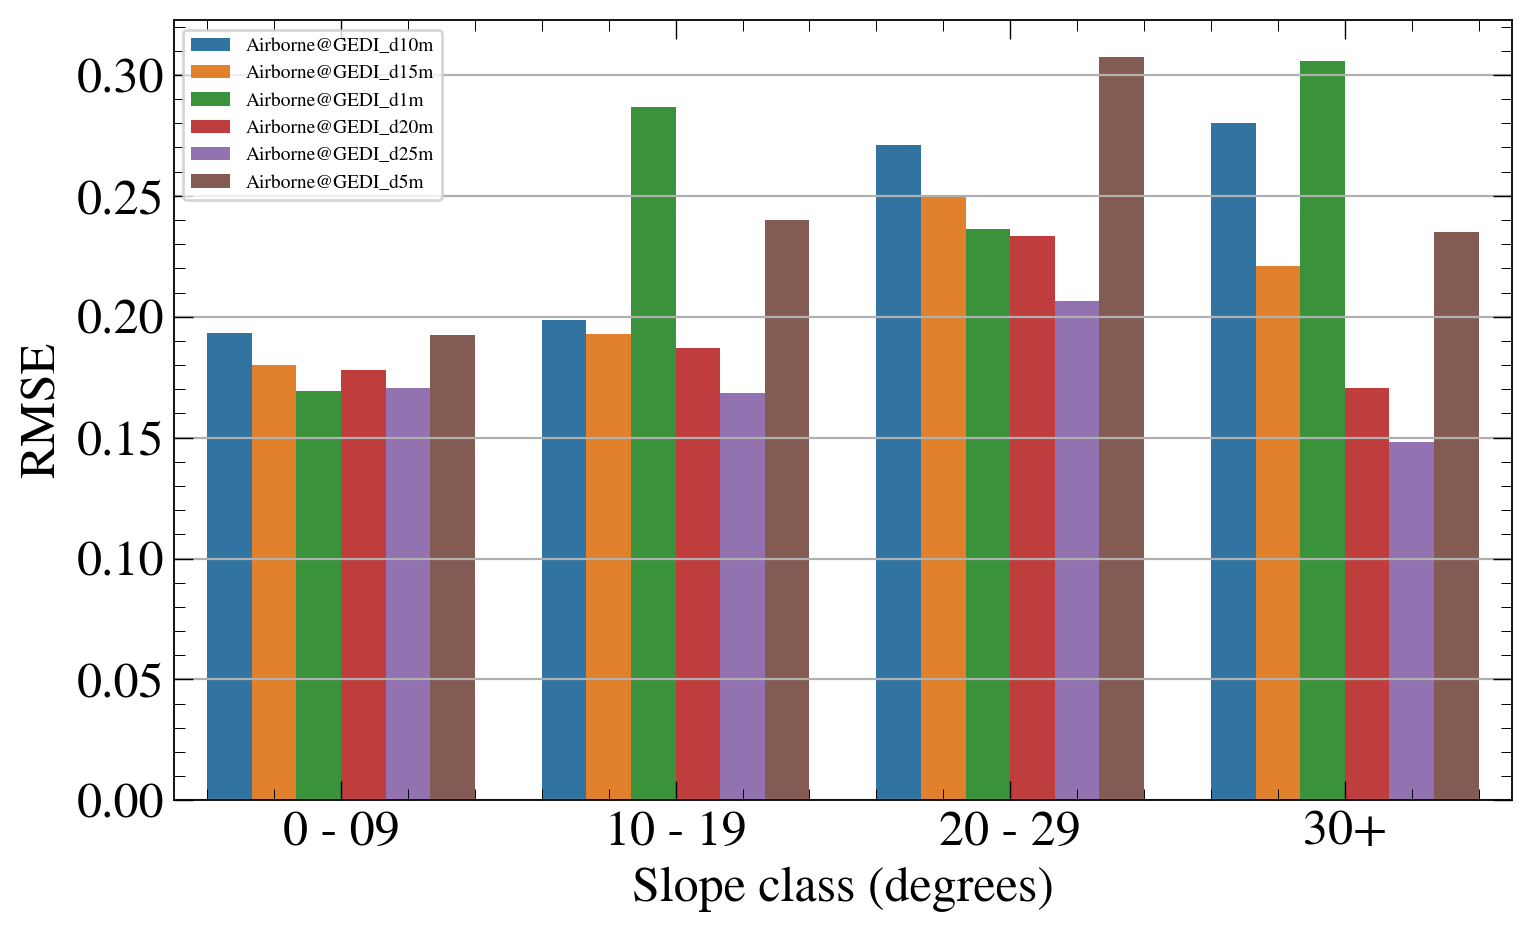

In [20]:
# # separate datasets
# results_gedi = results_df[results_df["dataset"].str.startswith("Airborne@GEDI")].copy()
# results_icesat2 = results_df[results_df["dataset"].str.startswith("Airborne@ATL08")].copy()

gedi_filename = "/bsuhome/tnde/scratch/carbon_estimation/data/gedi_data/gedi_finder/ml_data/results_airborne_gedi.csv"
icesat2_filename = Path("/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/ml_data/results_airborne_icesat2.csv")

results_gedi = pd.read_csv(gedi_filename)
results_icesat2 = pd.read_csv(icesat2_filename)

# ---------------------------------------------------
# Plot RMSE by slope class and dataset (Spatial RF) – Airborne@GEDI only
# ---------------------------------------------------
def plot_results(results_data, metric, origin):
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=results_data,
        x="slope_bin",
        y=metric,
        hue="dataset"
    )
    
    if metric in ["RMSE_RF_spatial", "RMSE_RF"]:
        plt.ylabel("RMSE")
        plt.xlabel("Slope class (degrees)")
        plt.legend(fontsize=7)  # , loc="lower left")
        plt.tight_layout()
    else:
        plt.ylabel("R-squared")
        plt.xlabel("Slope class (degrees)")
        # plt.title("R-squared across slope classes")
        plt.legend(fontsize=7, loc="lower left")
        plt.tight_layout()
        
    # if origin == "spatial":
    #     plt.title("Spatial RF performance across slope classes")
    # else:
    #     plt.title("RF performance across slope classes")
    plt.show()
    
# plot_results(results_icesat2, "RMSE_RF_spatial", "spatial")
plot_results(results_gedi, "RMSE_RF_spatial", "spatial")

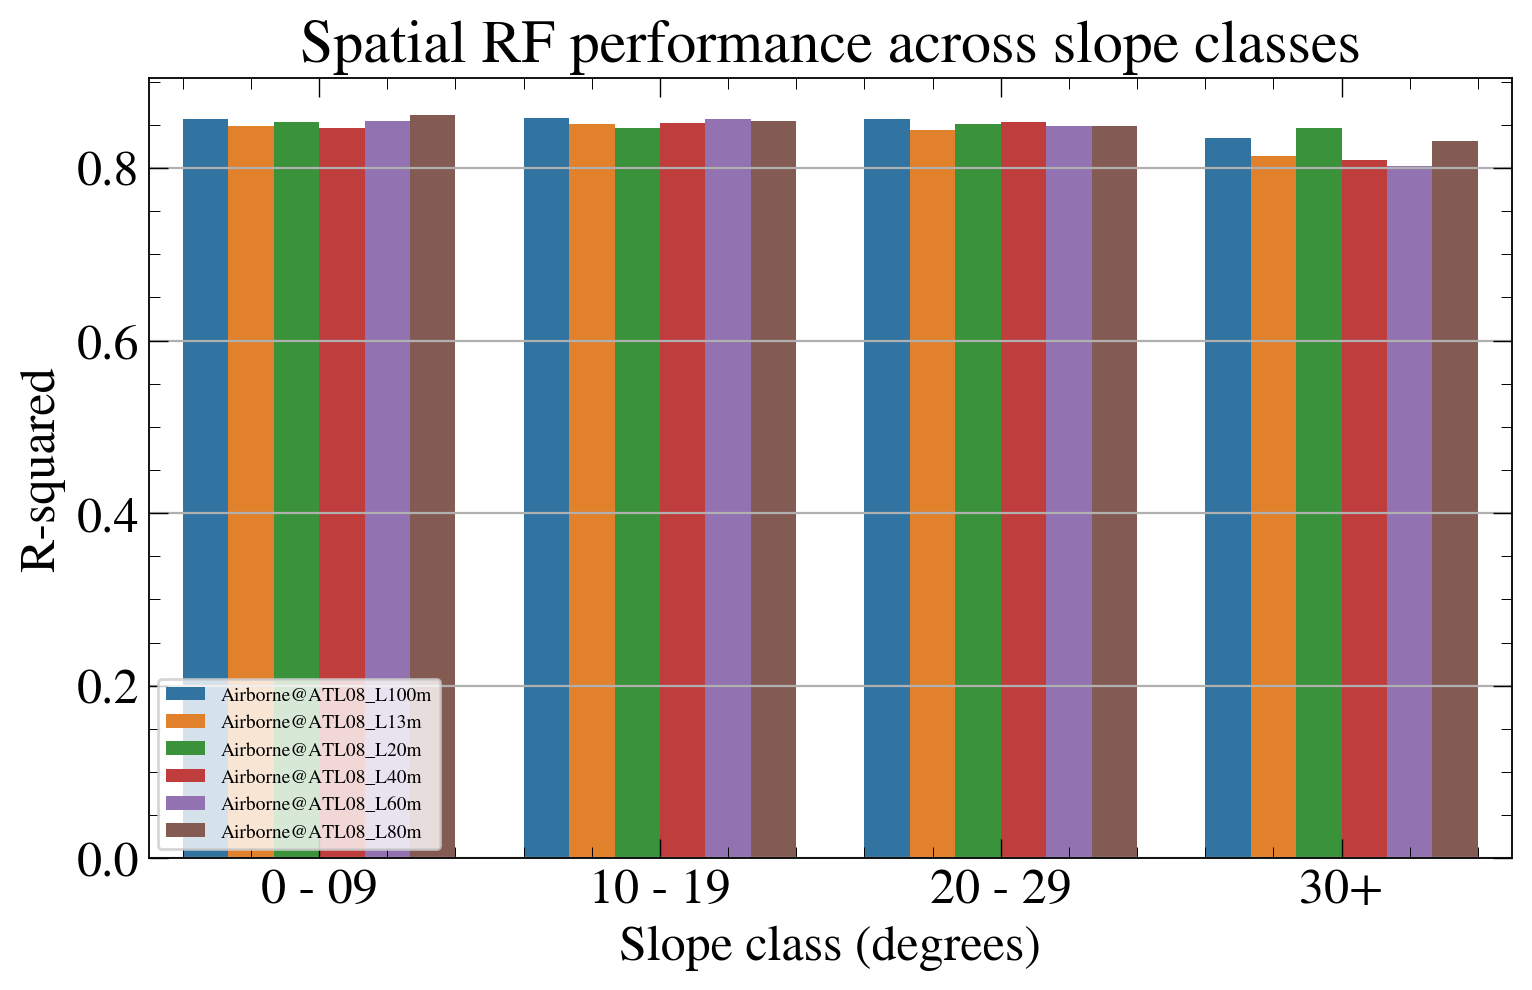

In [21]:
plot_results(results_icesat2, "R2_RF_spatial", "spatial")

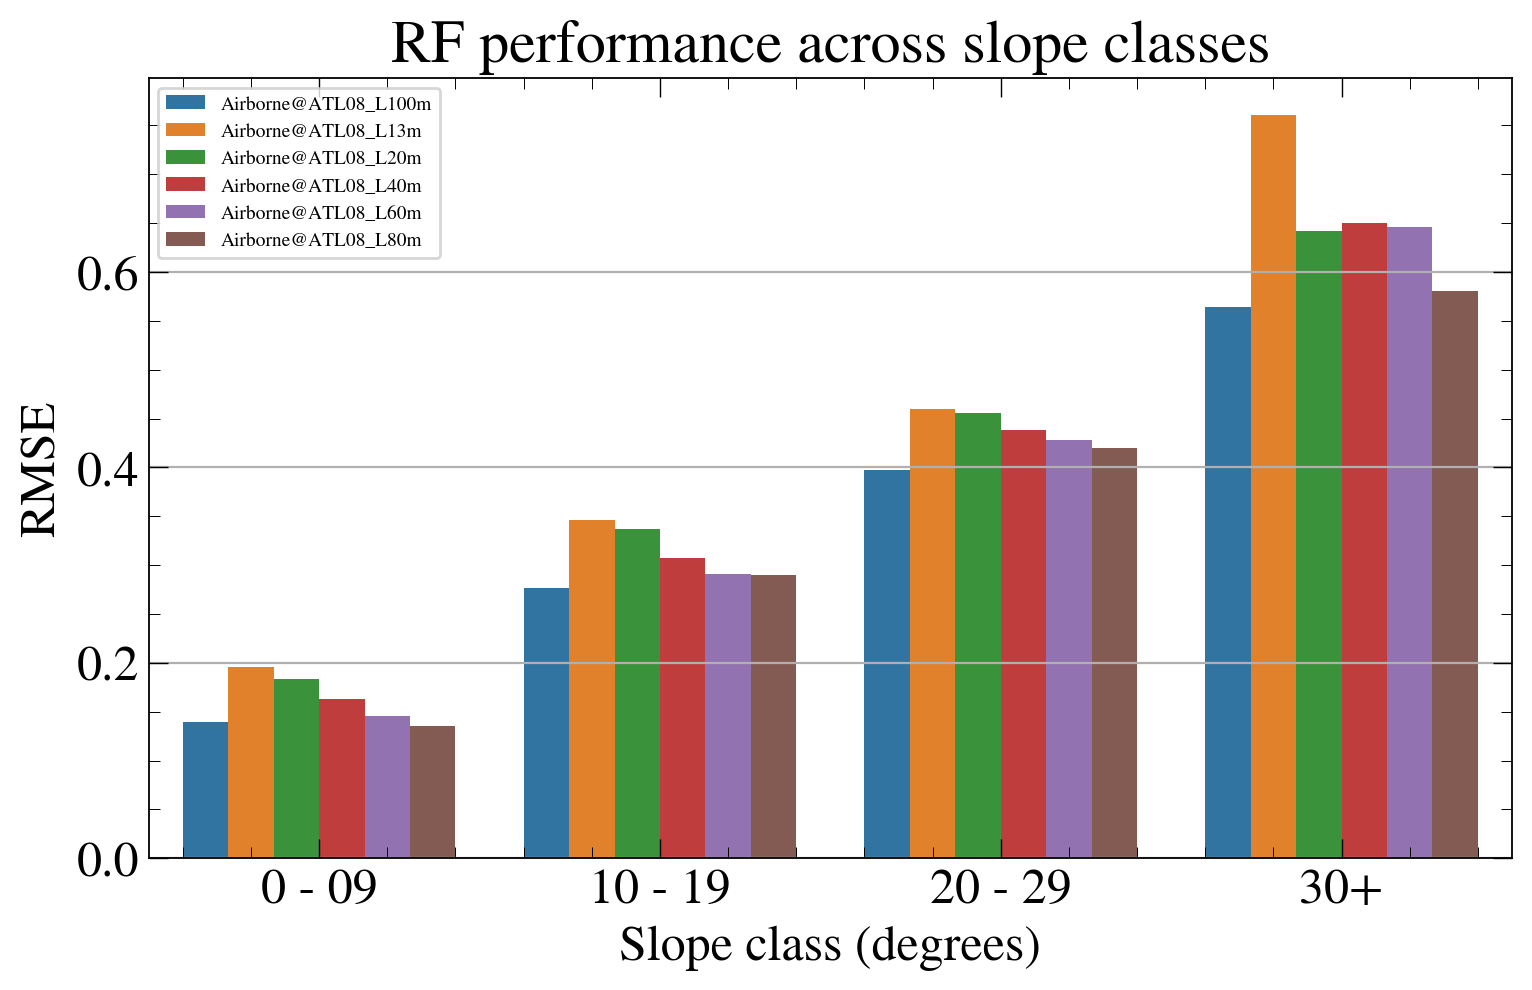

In [22]:
plot_results(results_icesat2, "RMSE_RF", "non_spatial")

In [ ]:
plot_results(results_gedi, "R2_RF", "non_spatial")

In [25]:
df_all_gedi_filename = "/bsuhome/tnde/scratch/carbon_estimation/data/gedi_data/gedi_finder/ml_data/results_airborne_gedi.csv"
df_all_icesat2_filename = Path("/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/ml_data/results_airborne_icesat2.csv")

df_all_results_gedi = pd.read_csv(df_all_gedi_filename)
df_all_results_icesat2 = pd.read_csv(df_all_icesat2_filename)

### Rasters

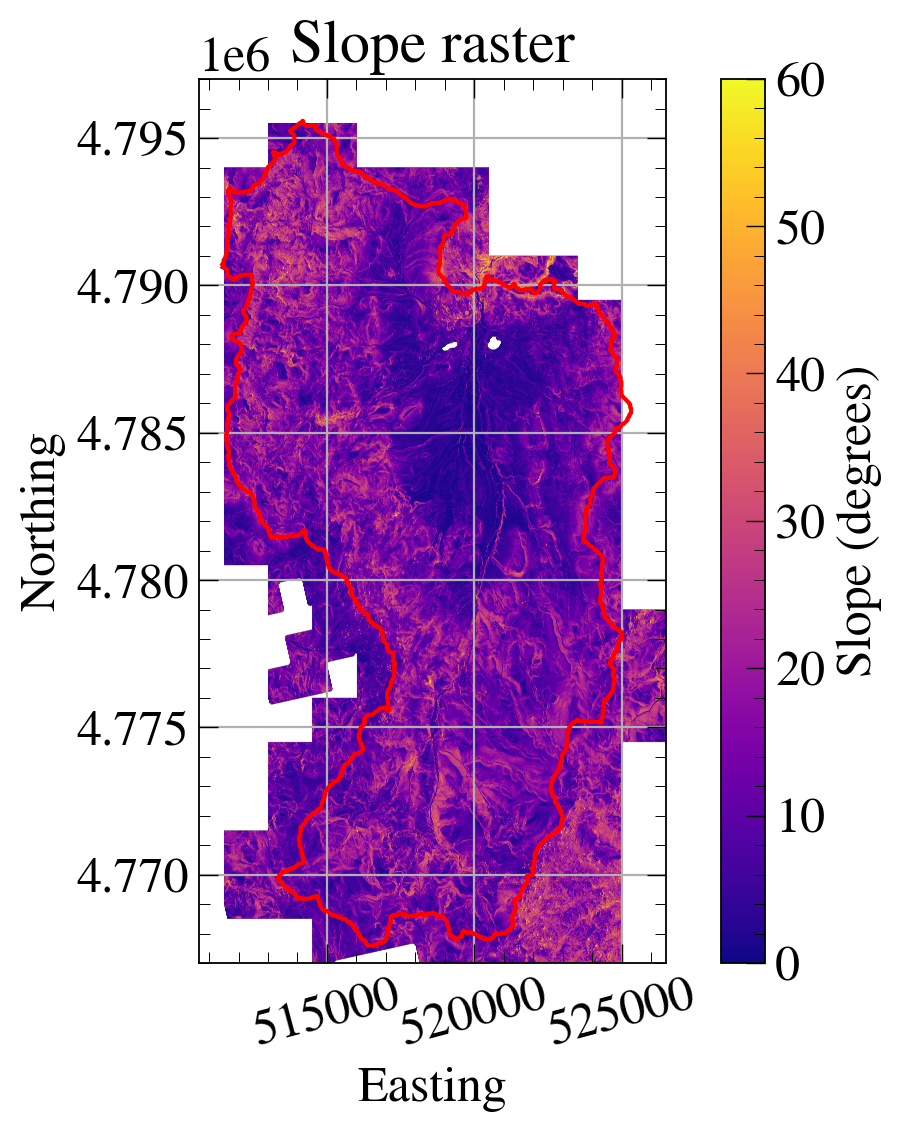

In [12]:
# -----------------------
# Paths
# -----------------------
dsm_path = "/bsuhome/tnde/scratch/carbon_estimation/airborne_lidar/mosaics/lidar_slope_deg.tif"
shp = "/bsuhome/tnde/geoscience/carbon_estimation/RCEW_shapefile_josh/RCEW_Boundary.shp"

with rasterio.open(dsm_path) as ds:
    arr = ds.read(1, masked=True)  # nodata -> mask
    extent = plotting_extent(ds)
    raster_crs = ds.crs

# -------------------------------
# Read shapefile and match CRS
# -------------------------------
shapefile = gpd.read_file(shp)
# Reproject shapefile to raster CRS
shapefile = shapefile.to_crs(raster_crs)
   
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(arr, vmin=0, vmax=60, extent=extent, origin="upper", cmap="plasma")
ax.tick_params(axis='x', rotation=15)

# Shapefile overlay (as outline)
shapefile.boundary.plot(ax=ax, edgecolor="red", linewidth=1.5)

ax.set_title("Slope raster")
ax.set_xlabel("Easting"); 
ax.set_ylabel("Northing")
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label("Slope (degrees)")
plt.tight_layout(); 
plt.show()

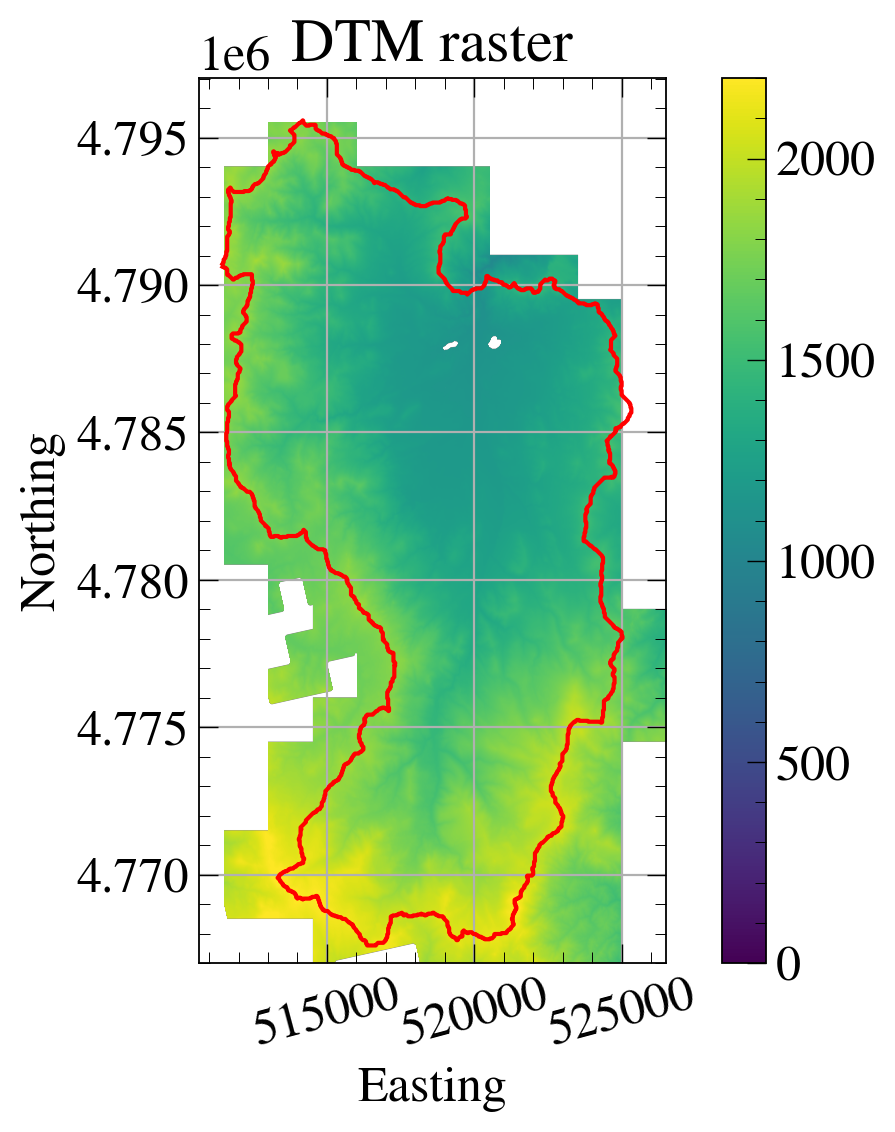

In [30]:
dsm_path = "/bsuhome/tnde/scratch/carbon_estimation/airborne_lidar/mosaics/lidar_dtm_mosaic.tif"
with rasterio.open(dsm_path) as ds:
    arr = ds.read(1, masked=True)  # nodata -> mask
    extent = plotting_extent(ds)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(arr, vmin=0, vmax=2200, extent=extent, origin="upper", cmap="viridis")
ax.tick_params(axis='x', rotation=15)

# Shapefile overlay (as outline)
shapefile.boundary.plot(ax=ax, edgecolor="red", linewidth=1.5)

ax.set_title("DTM raster")
ax.set_xlabel("Easting"); 
ax.set_ylabel("Northing")
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
# cbar.set_label("Elevation (m)")
plt.tight_layout(); 
plt.show()

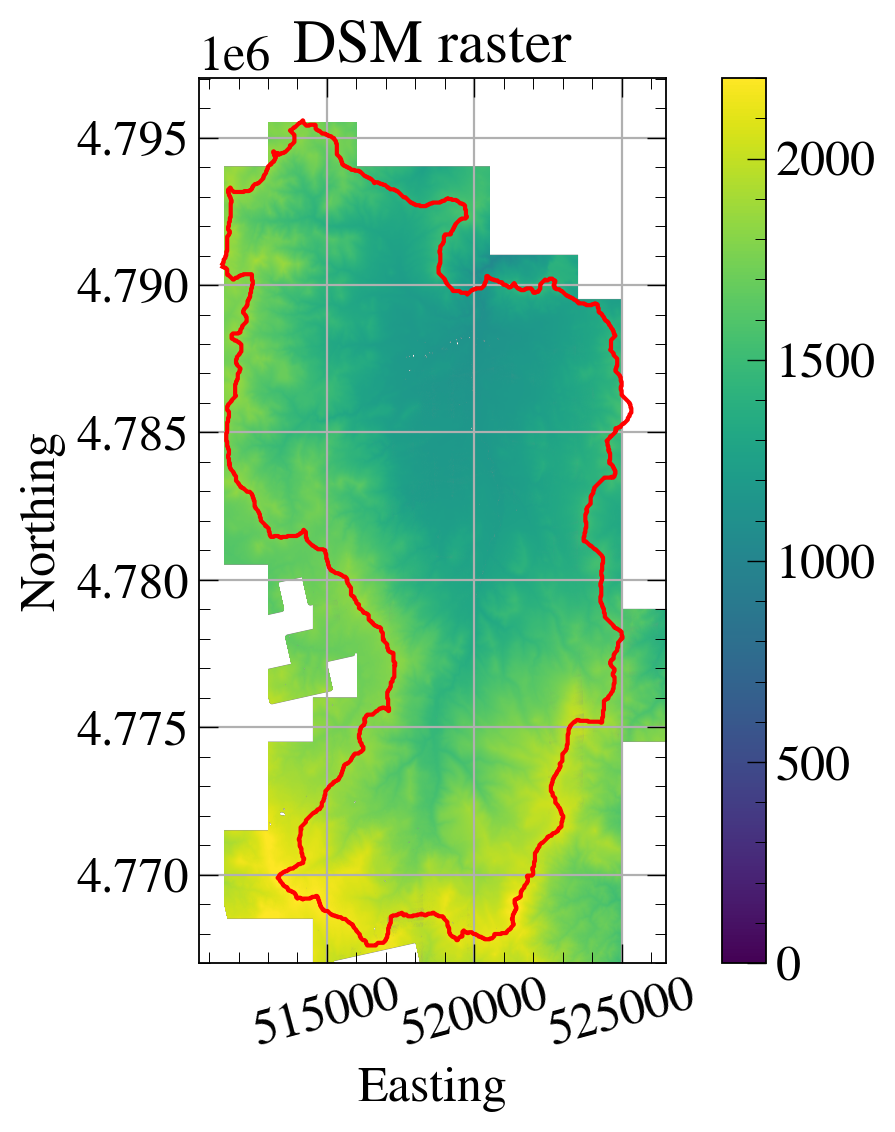

In [29]:
dsm_path = "/bsuhome/tnde/scratch/carbon_estimation/airborne_lidar/mosaics/lidar_dsm_mosaic.tif"
with rasterio.open(dsm_path) as ds:
    arr = ds.read(1, masked=True)  # nodata -> mask
    extent = plotting_extent(ds)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(arr, vmin=0, vmax=2200, extent=extent, origin="upper", cmap="viridis")
ax.tick_params(axis='x', rotation=15)

# Shapefile overlay (as outline)
shapefile.boundary.plot(ax=ax, edgecolor="red", linewidth=1.5)

ax.set_title("DSM raster")
ax.set_xlabel("Easting"); 
ax.set_ylabel("Northing")
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
ax.set_label("Elevation (meters)")
plt.tight_layout(); 
plt.show()

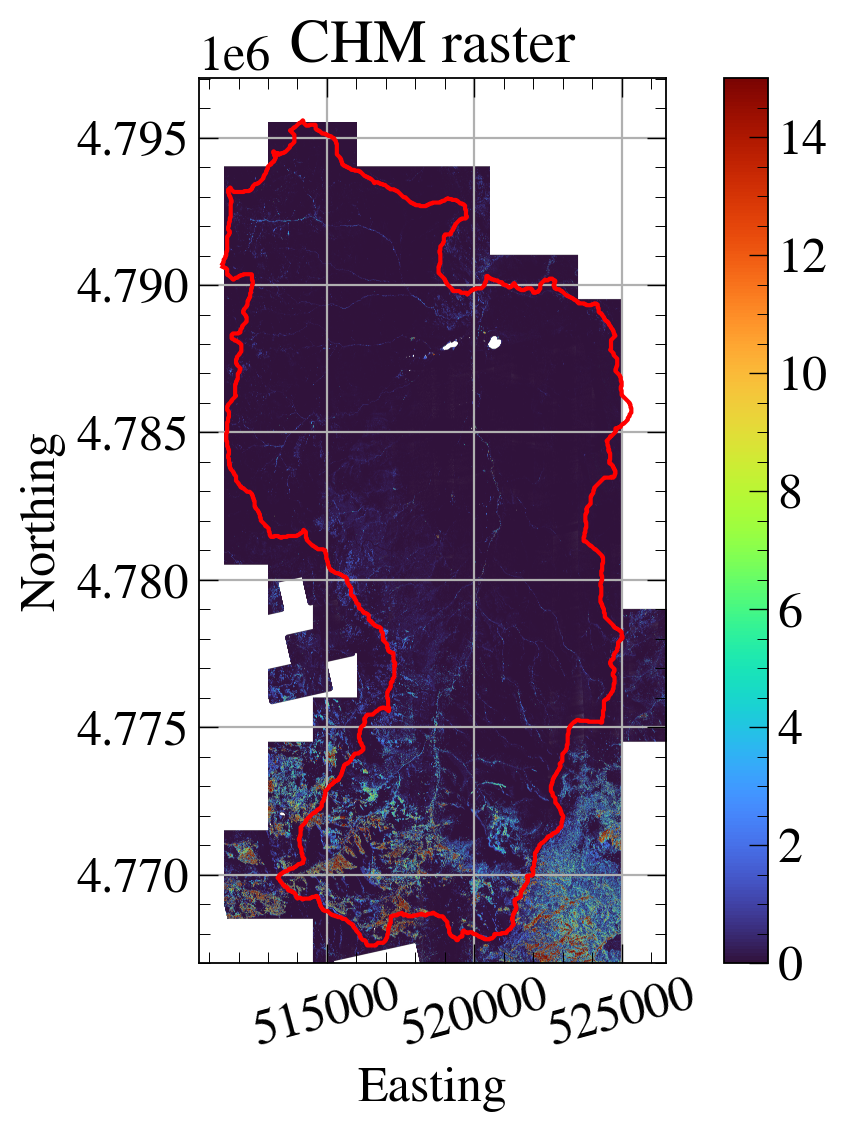

In [32]:
chm_path = "/bsuhome/tnde/scratch/carbon_estimation/airborne_lidar/mosaics/lidar_chm_mosaic.tif"
with rasterio.open(chm_path) as ds:
    arr = ds.read(1, masked=True)  # nodata -> mask
    extent = plotting_extent(ds)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(arr, extent=extent, origin="upper", cmap="turbo")
ax.tick_params(axis='x', rotation=15)

# Shapefile overlay (as outline)
shapefile.boundary.plot(ax=ax, edgecolor="red", linewidth=1.5)

ax.set_title("CHM raster")
ax.set_xlabel("Easting"); 
ax.set_ylabel("Northing")
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
# cbar.set_label("Elevation (meters)")
plt.tight_layout(); 
plt.show()

In [20]:
from sliderule import sliderule
# Specify region of interest from geojson
poly_fn = '/bsuhome/tnde/geoscience/carbon_estimation/RCEW_shapefile_josh/RCEW_Boundary.geojson'
pregion = gpd.read_file(poly_fn)
pregion = pregion.to_crs(projected_crs)
region = sliderule.toregion(poly_fn)["poly"] # symplify 

# Prepare coordinate lists for plotting the region of interest polygon
region_lon = [e["lon"] for e in region]
region_lat = [e["lat"] for e in region]

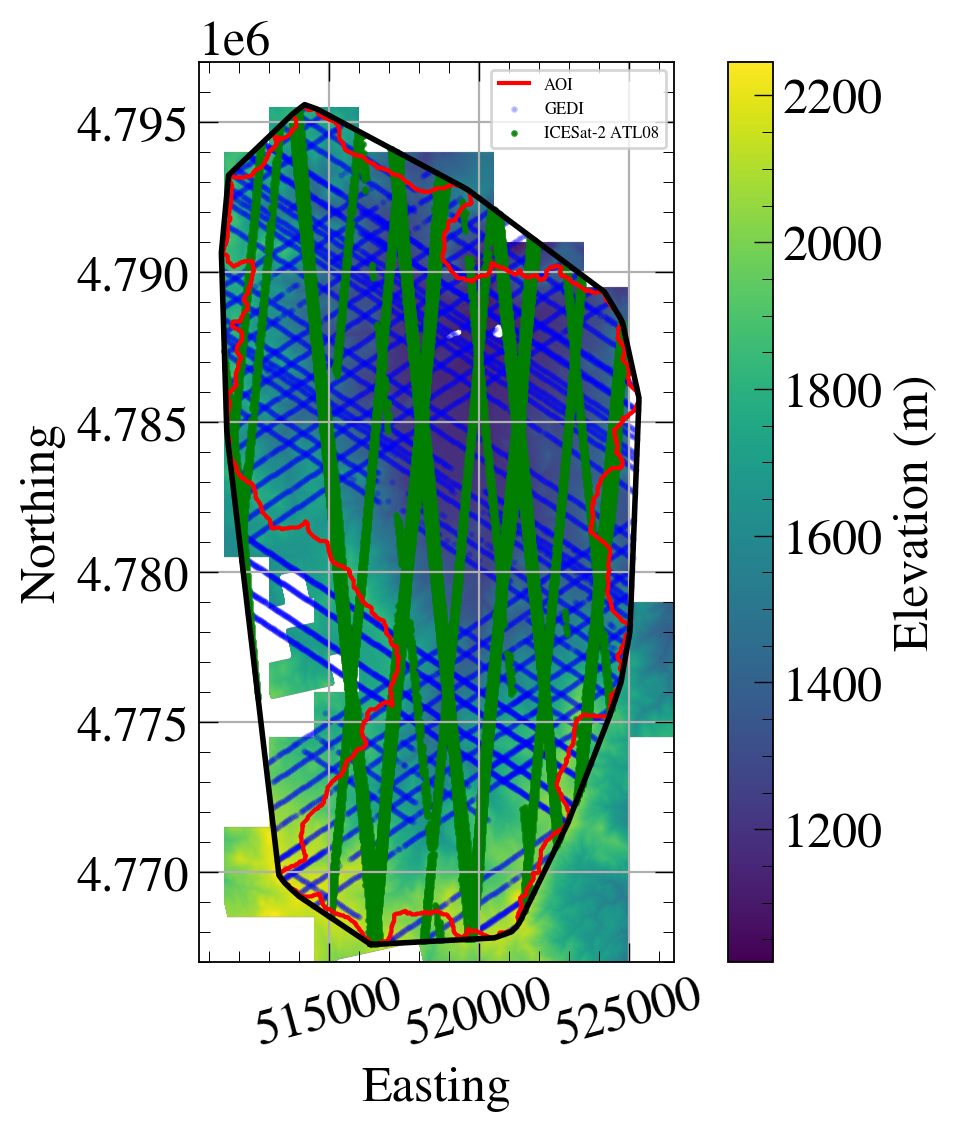

In [21]:
# import rasterio
# from rasterio.plot import plotting_extent
# import geopandas as gpd
# import matplotlib.pyplot as plt

dsm_path = "/bsuhome/tnde/scratch/carbon_estimation/airborne_lidar/mosaics/lidar_dtm_mosaic.tif"

with rasterio.open(dsm_path) as ds:
    arr = ds.read(1, masked=True)  # nodata -> mask
    extent = plotting_extent(ds)
    raster_crs = ds.crs

# --- Build GEDI GeoDataFrame from Easting/Northing ---
# adjust column names if different (e.g., "Easting_l2a", "Northing_l2a")
gedi_gdf = gpd.GeoDataFrame(
    gedi_data.copy(),
    geometry=gpd.points_from_xy(gedi_data["Easting_l2a"], gedi_data["Northing_l2a"]),
    crs=raster_crs  # set to raster CRS; change if needed
)

# If ICESat-2 is not in same CRS, reproject it
if icesat2_gdf_atl08.crs is None:
    # set manually if you know it:
    # icesat2_gdf_atl08 = icesat2_gdf_atl08.set_crs("EPSG:32612")
    pass

if icesat2_gdf_atl08.crs != raster_crs:
    icesat2_plot = icesat2_gdf_atl08.to_crs(raster_crs)
else:
    icesat2_plot = icesat2_gdf_atl08

# If shapefile is not already in raster CRS, reproject it too
if shapefile.crs != raster_crs:
    shapefile_plot = shapefile.to_crs(raster_crs)
else:
    shapefile_plot = shapefile

# --- Plot DTM + GEDI + ICESat-2 tracks ---
fig, ax = plt.subplots(figsize=(8, 6))

# DTM
im = ax.imshow(arr, extent=extent, origin="upper")
ax.tick_params(axis="x", rotation=15)

# AOI outline
shapefile_plot.boundary.plot(ax=ax, edgecolor="red", linewidth=1.5, label="AOI")

# GEDI footprints / track
gedi_gdf.plot(
    ax=ax,
    markersize=2,
    color="blue",
    alpha=0.2,
    label="GEDI"
)

# ICESat-2 ATL08 footprints / track
icesat2_plot.plot(
    ax=ax,
    markersize=2,
    color="green",
    alpha=0.8,
    label="ICESat-2 ATL08"
)

ax.plot(region_lon, region_lat, linewidth=2, color='k')

# ax.set_title("RCEW")
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")

# cbar = plt.colorbar(im, fraction=0.046, pad=0.40, location="left")
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label("Elevation (m)")

ax.legend(loc="upper right", fontsize=6)
plt.tight_layout()
plt.show()


## Spatial RF with slope

In [2]:
# =========================
# CONFIG
# =========================
# Input tile directories: GeoTIFF tiles
DTM_DIR = Path("/bsuhome/tnde/scratch/carbon_estimation/airborne_lidar/las_dtm/")    # DTM
DSM_DIR = Path("/bsuhome/tnde/scratch/carbon_estimation/airborne_lidar/lasgrid_dsm/")    # DSM

# Optionally, set CHM_DIR and skip DSM
CHM_DIR = None  # e.g., Path("/path/to/chm_tiles") or None

# Outputs
OUT_DIR = Path(Path("/bsuhome/tnde/scratch/carbon_estimation/airborne_lidar/mosaics/") )
OUT_DIR.mkdir(parents=True, exist_ok=True)

DTM_MOSAIC = OUT_DIR / "lidar_dtm_mosaic.tif"
DSM_MOSAIC = OUT_DIR / "lidar_dsm_mosaic.tif"
CHM_MOSAIC = OUT_DIR / "lidar_chm_mosaic.tif"
SLOPE_MOSAIC = OUT_DIR / "lidar_slope_deg.tif"

# GEDI and ATL08 vectors
GEDI_VECT = Path("/bsuhome/tnde/scratch/carbon_estimation/data/gedi_data/gedi_finder/ml_data/gedi_ml2.geojson")
ATL08_VECT = Path("/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/ml_data/icesat2_ml_final.geojson")

# Column names for vegetation height in the vector attribute tables
gedi_height_col = "rh_80"          # or "rh_100"
atl08_height_col = "h_mean_canopy"     # or "h_max_canopy"

# Approximate footprint buffers (meters)
gedi_buffer_m = 12.5

# CRS to use for all rasters and vectors (projected! so the buffers are in meters)
# If DTM tiles already have a projected CRS, you can leave this as None to keep native.
TARGET_CRS = None  # e.g., "EPSG:6340" or None

# ---------------------
# Utility: find rasters
# ---------------------
def list_tifs(folder: Path):
    return sorted([str(p) for p in folder.glob("*.tif")])

# --------------------------------
# Mosaic tiles into one GeoTIFF
# --------------------------------
def mosaic_tiles(tif_list, dst_path, target_crs=None, dst_dtype="float32", resampling=Resampling.bilinear):
    if len(tif_list) == 0:
        raise FileNotFoundError(f"No GeoTIFFs found to mosaic for {dst_path}")
    srcs = [rasterio.open(p) for p in tif_list]

    # Reproject on the fly if target_crs is requested and differs
    if target_crs is not None:
        target_crs = CRS.from_user_input(target_crs)

    # Merge (note: rasterio.merge will reproject if 'precision' and 'res' differ. We will keep simple merge.)
    mosaic, out_transform = rasterio.merge.merge(srcs, resampling=resampling)
    out_meta = srcs[0].meta.copy()
    out_meta.update({
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_transform,
        "dtype": dst_dtype
    })

    # Write temp
    with rasterio.open(dst_path, "w", **out_meta) as dst:
        dst.write(mosaic.astype(dst_dtype))

    # Optionally, reproject to target_crs
    if target_crs is not None and out_meta.get("crs") and CRS.from_user_input(out_meta["crs"]) != target_crs:
        reproj_path = dst_path.with_name(dst_path.stem + f"_{target_crs.to_authority()[0]}{target_crs.to_authority()[1]}.tif")
        reproject_to(dst_path, reproj_path, target_crs)
        os.replace(reproj_path, dst_path)

    for s in srcs:
        s.close()

    return str(dst_path)

# ---------------------------
# Reproject a raster to a CRS
# ---------------------------
def reproject_to(src_path, dst_path, target_crs):
    with rasterio.open(src_path) as src:
        transform, width, height = rasterio.warp.calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update({
            "crs": target_crs,
            "transform": transform,
            "width": width,
            "height": height
        })
        with rasterio.open(dst_path, "w", **kwargs) as dst:
            for i in range(1, src.count + 1):
                rasterio.warp.reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.bilinear
                )
    return str(dst_path)

# ----------------------------------------
# Compute CHM mosaic as DSM - DTM 
# ----------------------------------------
def compute_chm(dsm_path, dtm_path, out_path, nodata_out=-9999, max_height=15):
    with rasterio.open(dsm_path) as dsm, rasterio.open(dtm_path) as dtm:
        if dsm.crs != dtm.crs:
            raise ValueError("DSM and DTM must share the same CRS. Reproject first.")
        if (dsm.transform != dtm.transform) or (dsm.width != dtm.width) or (dsm.height != dtm.height):
            raise ValueError("DSM and DTM grids must be aligned. Resample/reproject one to the other.")

        dsm_arr = dsm.read(1).astype("float32")
        dtm_arr = dtm.read(1).astype("float32")

        # Build valid mask from nodata or non-finite
        dsm_nd = dsm.nodata
        dtm_nd = dtm.nodata
        valid = np.isfinite(dsm_arr) & np.isfinite(dtm_arr)
        if dsm_nd is not None:
            valid &= dsm_arr != dsm_nd
        if dtm_nd is not None:
            valid &= dtm_arr != dtm_nd

        chm = np.full_like(dtm_arr, np.float32(nodata_out))
        chm[valid] = dsm_arr[valid] - dtm_arr[valid]

        # Clean up: no negatives, and cap improbable outliers
        chm[valid & (chm < 0)] = 0.0
        chm[valid & (chm > max_height)] = max_height  # optional but helpful for plotting

        meta = dtm.meta.copy()
        meta.update(dtype="float32", nodata=nodata_out)

        with rasterio.open(out_path, "w", **meta) as dst:
            dst.write(chm, 1)

    return str(out_path)

# --------------------
# Compute slope (degrees)
# --------------------
def compute_slope_deg(dtm_path, out_path):
    dem = rd.LoadGDAL(str(dtm_path))
    slope = rd.TerrainAttribute(dem, attrib='slope_degrees')
    rd.SaveGDAL(str(out_path), slope)
    return str(out_path)

# ---------------------------------------------------------
# Buffer points in meters (handles reprojection for buffer)
# ---------------------------------------------------------
def buffer_points(gdf, buffer_m, target_crs=None):
    """
    Returns polygons (buffers) in a projected CRS so 'buffer_m' is in meters.
    If target_crs is None, uses the current CRS if it's projected; otherwise raises.
    """
    if target_crs is None:
        # If gdf.crs is geographic (degrees), you must pass a projected CRS
        if gdf.crs is None or CRS.from_user_input(gdf.crs).is_geographic:
            raise ValueError("Geographic CRS detected. Please set TARGET_CRS to a projected CRS (meters).")
        work_crs = gdf.crs
        gdf_proj = gdf
    else:
        work_crs = CRS.from_user_input(target_crs)
        gdf_proj = gdf.to_crs(work_crs)

    gdf_proj = gdf_proj.copy()
    gdf_proj["geometry"] = gdf_proj.geometry.buffer(buffer_m)
    return gdf_proj

# ----------------------------------------------------------
# Zonal stats helper: get mean/std/p95 from raster per geom
# ----------------------------------------------------------
def zonal_stats_df(geoms_gdf, raster_path, stats=("mean","std","percentile_95"), prefix="slope_"):
    zs = zonal_stats(
        geoms_gdf,
        raster_path,
        stats=list(stats),
        nodata=None,
        geojson_out=False
    )
    out = pd.DataFrame(zs)
    out = out.add_prefix(prefix)
    # out = out[out["slope_mean"].notna()]
    return out

# ---------- ICESat-2 helpers: track ends + rectangle corners ----------

def icesat2_gt_endflag(df: pd.DataFrame) -> np.ndarray:
    """
    Flag starts/ends of tracks defined by (date, gt).
    Assumes df has columns: 'time' (datetime64) and 'gt' (beam/ground track).
    Logically find the ends of unique ICESat-2 ground tracks according to dates.
    
    Steps:
    - We sort data first by time and then ground track (gt) to make sure all the points are ordered correctly. 
    - Use the unique function to identify the first instance of unique pairs of date and gt in the dataset thus giving the start of a new track. 
    - Identify the row above each track start as the end of the previous track.
    
    Parameters:
    - icesat2_df: ICESat-2 dataframe, assumed to be a pandas DataFrame with 'time' (datetime64), 'gt' (beam), and 'norths' already defined.

    Returns:
    - end_flag: 0/1 array same length as df - logical array indicating last point in each track. It is a binary array indicating where new tracks begin/end. 
      It is helps to avoid wrapping errors at track edges.
    """
    
    # Sort by 'time' and 'gt'
    sdf = df.sort_values(by=["time", "gt"]).reset_index(drop=True)
    
    # Extract only the date (ignore time of day)
    dates = pd.to_datetime(sdf["time"]).dt.date
    
    # Create a combined key of date and 'gt' and find first occurrence
    first_idx = pd.DataFrame({"date": dates, "gt": sdf["gt"]}).drop_duplicates(keep="first").index
    
    # Initialize end_flag with zeros (same length as number of rows)
    end_flag = np.zeros(len(sdf), dtype=int)
    
    # Flag unique_refs
    end_flag[first_idx] = 1
    
    # Also flag the entry just before each unique_ref (unless it's 0)
    for idx in first_idx:
        if idx > 0:
            end_flag[idx - 1] = 1
            
    # Flag the last element
    end_flag[-1] = 1
    return end_flag
    # Return in original row order
    # ef = pd.Series(end_flag, index=sdf.index)
    # return ef#.sort_index().values

def icesat2_footprint_corners(norths: np.ndarray,
                              easts: np.ndarray,
                              default_length: float,
                              end_flag: np.ndarray):
    """
    Calculate ICESat-2 footprint corners and orientation angles.
    This code inherently includes bearing-based orientation using the geometry of the ground track.
    
    Build oriented rectangles using local track bearing.
    theta is computed as arctan2(dN, dE) -> angle from East (x-axis)
    
    Parameters:
    - norths: array of northing coordinates.
    - easts: array of easting coordinates.
    - default_length: default footprint length (e.g., 100 for ATLO8 or 40 meters for ATL06).
    - end_flag: logical array indicating last point in each track. It is a binary array indicating where new tracks begin/end. 
      It is helps to avoid wrapping errors at track edges.

    Returns:
    - xc: x corner coordinates (N x 6)
    - yc: y corner coordinates (N x 6)
    - theta: footprint orientation angles (N,). The angle theta between the icesat2 track and due east
    """
    footwidth = 13.0  # meters (full width)
    n = norths.shape[0]
    theta = np.full((n, 2), np.nan, dtype="float64")
    xc = np.full((n, 6), np.nan, dtype="float64")
    yc = np.full((n, 6), np.nan, dtype="float64")

    # create polygons of ICESat-2 footprints
    for r in range(n-1):
        if r == 0 or (end_flag[r] - end_flag[r-1]) == 0: # only angle pointed forwards
            theta[r, 0] = np.degrees(np.arctan2(norths[r+1]-norths[r], easts[r+1]-easts[r]))
            theta[r, 1] = theta[r, 0]
            footlength = default_length
        elif r == n-1 or (end_flag[r] - end_flag[r+1]) == 0: # only angle pointed backwards
            theta[r, 0] = np.degrees(np.arctan2(norths[r]-norths[r-1], easts[r]-easts[r-1]))
            theta[r, 1] = theta[r, 0]
            footlength = default_length
        else: # calculate angles in each direction
            theta[r, 0] = np.degrees(np.arctan2(norths[r]-norths[r-1], easts[r]-easts[r-1]))
            theta[r, 1] = np.degrees(np.arctan2(norths[r+1]-norths[r], easts[r+1]-easts[r]))
            # footlength = 0.5 * np.hypot(norths[r+1]-norths[r-1], easts[r+1]-easts[r-1])
            footlength = 0.5 * np.sqrt((norths[r + 1] - norths[r - 1])**2 + (easts[r + 1] - easts[r - 1])**2)

        # along-track ends (angle from East). Find box edges along the RGT
        back_x  = easts[r] - (footlength/2.0) * np.cos(np.radians(theta[r, 0]))
        back_y  = norths[r] - (footlength/2.0) * np.sin(np.radians(theta[r, 0]))
        front_x = easts[r] + (footlength/2.0) * np.cos(np.radians(theta[r, 1]))
        front_y = norths[r] + (footlength/2.0) * np.sin(np.radians(theta[r, 1]))

        mean_theta = np.nanmean(theta[r, :])

        # cross-track offsets at center. Find box edges perpendicular to the centroid
        xc[r, 0] = easts[r] + (footwidth/2.0) * np.cos(np.radians(mean_theta + 90))
        yc[r, 0] = norths[r] + (footwidth/2.0) * np.sin(np.radians(mean_theta + 90))
        xc[r, 1] = easts[r] + (footwidth/2.0) * np.cos(np.radians(mean_theta - 90))
        yc[r, 1] = norths[r] + (footwidth/2.0) * np.sin(np.radians(mean_theta - 90))

        # rectangle corners at back and front. Solve for corner coordinates
        xc[r, 2] = back_x  + (footwidth/2.0) * np.cos(np.radians(theta[r, 0] + 90))
        yc[r, 2] = back_y  + (footwidth/2.0) * np.sin(np.radians(theta[r, 0] + 90))
        xc[r, 3] = back_x  + (footwidth/2.0) * np.cos(np.radians(theta[r, 0] - 90))
        yc[r, 3] = back_y  + (footwidth/2.0) * np.sin(np.radians(theta[r, 0] - 90))
        xc[r, 4] = front_x + (footwidth/2.0) * np.cos(np.radians(theta[r, 1] - 90))
        yc[r, 4] = front_y + (footwidth/2.0) * np.sin(np.radians(theta[r, 1] - 90))
        xc[r, 5] = front_x + (footwidth/2.0) * np.cos(np.radians(theta[r, 1] + 90))
        yc[r, 5] = front_y + (footwidth/2.0) * np.sin(np.radians(theta[r, 1] + 90))

    return xc, yc

# ---------------------------------------------------
# pipeline: mosaic, slope, CHM
# ---------------------------------------------------
# Mosaic DTM
dtm_tiles = list_tifs(DTM_DIR)
m_dtm = mosaic_tiles(dtm_tiles, DTM_MOSAIC, target_crs=TARGET_CRS, dst_dtype="float32")

# CHM (either from DSM tiles or CHM tiles)
have_chm = False
if CHM_DIR is not None:
    chm_tiles = list_tifs(CHM_DIR)
    if len(chm_tiles) > 0:
        m_chm = mosaic_tiles(chm_tiles, CHM_MOSAIC, target_crs=TARGET_CRS, dst_dtype="float32")
        have_chm = True

elif DSM_DIR is not None and len(list_tifs(DSM_DIR)) > 0:
    # Mosaic DSM, then CHM
    m_dsm = mosaic_tiles(list_tifs(DSM_DIR), DSM_MOSAIC, target_crs=TARGET_CRS, dst_dtype="float32")
    # Make sure DSM and DTM mosaics share grid; reproject DSM to DTM's exact grid if needed
    with rasterio.open(m_dtm) as dtm_src, rasterio.open(m_dsm) as dsm_src:
        if (dsm_src.crs != dtm_src.crs) or (dsm_src.transform != dtm_src.transform) \
           or (dsm_src.width != dtm_src.width) or (dsm_src.height != dtm_src.height):
            # Resample DSM to DTM grid
            aligned_dsm = OUT_DIR / "lidar_dsm_mosaic_aligned.tif"
            with rasterio.open(aligned_dsm, "w", **dtm_src.meta) as dst:
                dst_arr = dst.read(1)  # just to allocate; we will overwrite
            with rasterio.open(m_dsm) as s, rasterio.open(str(aligned_dsm), "r+") as d:
                dst_arr = np.empty((dtm_src.height, dtm_src.width), dtype="float32")
                rasterio.warp.reproject(
                    source=rasterio.band(s, 1),
                    destination=dst_arr,
                    src_transform=s.transform,
                    src_crs=s.crs,
                    dst_transform=dtm_src.transform,
                    dst_crs=dtm_src.crs,
                    resampling=Resampling.bilinear
                )
                d.write(dst_arr, 1)
            m_dsm = str(aligned_dsm)

    m_chm = compute_chm(m_dsm, m_dtm, CHM_MOSAIC)
    have_chm = True

# Slope (degrees)
m_slope = compute_slope_deg(m_dtm, SLOPE_MOSAIC)

# -------------------------------------------------------
# Load vectors and prep buffers (projected CRS required)
# -------------------------------------------------------
target_col = "rh_80" # "rh_100"
gedi = gpd.read_file(GEDI_VECT)
gedi = gedi.drop(drop_cols, axis = 1)
gedi = gedi.rename(columns={"elevation_NAVD88_gedi_from_crs_l2a": "Elevation"})
gedi = gedi[gedi["fhd_normal"] != -9999.000000]
gedi = gedi[gedi[target_col] <= 15]
gedi[target_col] = pd.to_numeric(gedi[target_col], errors="coerce").clip(upper=15)
# gedi.head()

from helper_functions import load_icesat2_data
projected_crs = "epsg:6340" 
# atl08 = gpd.read_file(ATL08_VECT)
atl08 = load_icesat2_data(ATL08_VECT, "ATL08", process = False)
# atl08 = atl08[atl08["gnd_ph_count"] != 0]
atl08 = atl08[atl08["h_mean_canopy"] <= 15]
atl08[atl08_height_col] = pd.to_numeric(atl08[atl08_height_col], errors="coerce").clip(upper=15)
atl08 = atl08.rename(columns={"elevation_NAVD88_icesat2_from_crs": "Elevation"})
print(f"Length of data: {len(atl08)}")
print(atl08.crs, "\n")

with rasterio.open(m_slope) as rs:
    raster_crs = rs.crs

# Reproject vectors to raster CRS (must be projected to use meter buffers)
if CRS.from_user_input(raster_crs).is_geographic:
    raise ValueError("Slope raster is in a geographic CRS. Reproject DTM to a projected CRS (meters).")

gedi = gedi.to_crs(raster_crs)
atl08 = atl08.to_crs(raster_crs)

gedi_buf = buffer_points(gedi, gedi_buffer_m, target_crs=None)   # already projected

# ---------- Build 100x13 m oriented rectangles for ATL08 ----------
# ATL08 is already projected to the raster CRS (meters) above
# Required columns: 'Easting', 'Northing', 'time' (datetime64), 'gt' (beam/track id)

# End flags (avoid wrapping across tracks/days)
ef = icesat2_gt_endflag(atl08)

# Rectangle corners 
norths = pd.to_numeric(atl08["Northing"], errors="coerce").values
easts  = pd.to_numeric(atl08["Easting"],  errors="coerce").values
xc, yc = icesat2_footprint_corners(norths, easts, default_length=100.0, end_flag=ef)

# Build shapely Polygons from corners (use indices we actually filled)
from shapely.geometry import Polygon
rows = []
rect_geoms = []
for i in range(xc.shape[0]):
    if np.any(np.isnan(xc[i, 2:6])) or np.any(np.isnan(yc[i, 2:6])):
        continue
    rect = ShpPolygon([(xc[i,2], yc[i,2]), 
                       (xc[i,3], yc[i,3]), 
                       (xc[i,4], yc[i,4]), 
                       (xc[i,5], yc[i,5])])
    rect_geoms.append(rect)
    rows.append(i)

# Create a GeoDataFrame aligned to the kept rows
atl08_rects = atl08.iloc[rows].copy()
atl08_rects.set_geometry(gpd.GeoSeries(rect_geoms, index=atl08_rects.index), inplace=True)
# (CRS already set via atl08.to_crs(raster_crs) earlier)

# ---------------------------------------------------
# Zonal stats: slope under GEDI and ATL08 footprints
# ---------------------------------------------------
gedi_slope_df = zonal_stats_df(
    gedi_buf, m_slope,
    stats=("mean", "std", "percentile_95"),
    prefix="slope_"
)
atl08_slope_df = zonal_stats_df(
    atl08_rects, m_slope,
    stats=("mean", "std", "percentile_95"),
    prefix="slope_"
)

# Attach back to GeoDataFrames
gediX = gedi.copy()
atl08X = atl08_rects.copy()
for col in gedi_slope_df.columns:
    gediX[col] = gedi_slope_df[col]
for col in atl08_slope_df.columns:
    atl08X[col] = atl08_slope_df[col]

# ---------------------------------------------------
# CHM stats (airborne height) under footprints
# ---------------------------------------------------
def chm_stats_df(geoms_gdf, chm_path, prefix="chm_"):
    return zonal_stats_df(
        geoms_gdf, chm_path,
        stats=("mean", "std", "percentile_95"),
        prefix=prefix
    )

if have_chm:
    # compute stats on the buffer polygons…
    gedi_chm_df  = chm_stats_df(gedi_buf,      m_chm, prefix="chm_")
    atl08_chm_df = chm_stats_df(atl08_rects,   m_chm, prefix="chm_")

    # …and attach them to the existing frames that already have slope columns
    for col in gedi_chm_df.columns:
        gediX[col] = gedi_chm_df[col]
    for col in atl08_chm_df.columns:
        atl08X[col] = atl08_chm_df[col]

if have_chm:
    # cap CHM-based heights to 15 m
    for df_ in (gediX, atl08X):
        if "chm_mean" in df_.columns:
            df_["chm_mean"] = pd.to_numeric(
                df_["chm_mean"], errors="coerce"
            ).clip(upper=15)
        if "chm_percentile_95" in df_.columns:
            df_["chm_percentile_95"] = pd.to_numeric(
                df_["chm_percentile_95"], errors="coerce"
            ).clip(upper=15)

# ---------------------------------------------------
# DROP points with no slope or CHM under the buffer
# ---------------------------------------------------
if have_chm:
    # Require BOTH slope_mean and chm_mean to be present
    before_gedi  = len(gediX)
    before_atl08 = len(atl08X)

    gediX  = gediX[gediX["slope_mean"].notna() & gediX["chm_mean"].notna()].reset_index(drop=True)
    atl08X = atl08X[atl08X["slope_mean"].notna() & atl08X["chm_mean"].notna()].reset_index(drop=True)

    print(f"GEDI: kept {len(gediX)} / {before_gedi} points with valid slope and CHM")
    print(f"ATL08: kept {len(atl08X)} / {before_atl08} points with valid slope and CHM")
else:
    # Fallback: no CHM, so at least require slope
    before_gedi  = len(gediX)
    before_atl08 = len(atl08X)

    gediX  = gediX[gediX["slope_mean"].notna()].reset_index(drop=True)
    atl08X = atl08X[atl08X["slope_mean"].notna()].reset_index(drop=True)

    print(f"GEDI: kept {len(gediX)} / {before_gedi} points with valid slope")
    print(f"ATL08: kept {len(atl08X)} / {before_atl08} points with valid slope")

print("GEDI slope cols:", [c for c in gediX.columns if c.startswith("slope_")])
print("ATL08 slope cols:", [c for c in atl08X.columns if c.startswith("slope_")])

if have_chm:
    print("GEDI CHM cols:", [c for c in gediX.columns if c.startswith("chm_")])
    print("ATL08 CHM cols:", [c for c in atl08X.columns if c.startswith("chm_")])

assert "slope_mean" in gediX.columns and "slope_mean" in atl08X.columns
        
# ---------------------------------------------------
# Assemble tidy DataFrame for modeling
# ---------------------------------------------------
def build_df(gdf, dataset_name, height_col):
    # pull height and slope
    heights = pd.to_numeric(gdf[height_col], errors="coerce").astype("float32")
    slopes  = pd.to_numeric(gdf["slope_mean"], errors="coerce").astype("float32")

    # hard-cap heights at 15 m
    heights = heights.clip(upper=15)

    # coordinates for Spatial RF (assumes projected CRS in meters)
    centroids = gdf.geometry.centroid
    xs = centroids.x.astype("float32")
    ys = centroids.y.astype("float32")

    # elevation (if present; e.g., column "Elevation" in ATL08 or GEDI)
    elev = pd.to_numeric(gdf.get("Elevation", np.nan), errors="coerce").astype("float32")

    df = pd.DataFrame({
        "dataset":   dataset_name,
        "height_m":  heights,
        "slope_deg": slopes,
        "x":         xs,
        "y":         ys,
        "elev_m":    elev,
        "slope_std": pd.to_numeric(
            gdf.get("slope_std", np.nan), errors="coerce"
        ).astype("float32"),
        "slope_p95": pd.to_numeric(
            gdf.get("slope_percentile_95", np.nan), errors="coerce"
        ).astype("float32"),
        # keep original GeoDataFrame index so we can map residuals back later
        "src_idx":   gdf.index,
    }, index=gdf.index)

    # also cap CHM-related fields if present
    if "chm_mean" in gdf.columns:
        df["chm_mean"] = (
            pd.to_numeric(gdf["chm_mean"], errors="coerce")
            .astype("float32")
            .clip(upper=15)
        )
    if "chm_std" in gdf.columns:
        df["chm_std"] = pd.to_numeric(gdf["chm_std"], errors="coerce").astype("float32")
    if "chm_percentile_95" in gdf.columns:
        df["chm_p95"] = (
            pd.to_numeric(gdf["chm_percentile_95"], errors="coerce")
            .astype("float32")
            .clip(upper=15)
        )
    # we require height and slope and coordinates, but NOT elevation
    return df.dropna(subset=["height_m", "slope_deg", "x", "y"])

df_gedi = build_df(gediX, "GEDI", gedi_height_col)
df_atl8 = build_df(atl08X, "ATL08", atl08_height_col)

# If you also want airborne-as-truth at the same points, set height_m = chm_mean
df_airborne = None
if have_chm:
    # Sample slope and CHM at a hex/point grid could be done, but here we re-use footprints as support
    # Use CHM statistics as "height_m"
    tmp = df_gedi.copy()
    tmp["dataset"] = "Airborne@GEDI"
    tmp["height_m"] = tmp["chm_mean"]
    df_airborne = tmp.dropna(subset=["height_m","slope_deg"])

df_airborne_atl8 = None
if have_chm:
    tmp2 = df_atl8.copy()
    tmp2["dataset"] = "Airborne@ATL08"
    tmp2["height_m"] = tmp2.get("chm_mean", np.nan)
    # ensure 15 m cap (just in case)
    tmp2["height_m"] = pd.to_numeric(tmp2["height_m"], errors="coerce").clip(upper=15)
    df_airborne_atl8 = tmp2.dropna(subset=["height_m","slope_deg"])
    
# Combined for modeling and comparison
dfs = [df_gedi, df_atl8]
if df_airborne is not None:
    dfs.append(df_airborne)
if df_airborne_atl8 is not None:
    dfs.append(df_airborne_atl8)
df_all = pd.concat(dfs, ignore_index=True)

# ---------------------------------------------------
# Add slope bins for performance by slope class
# ---------------------------------------------------
# Define slope thresholds (in degrees)
bins = [0, 9, 19, 29, np.inf]
labels = ["0 - 09", "10 - 19", "20 - 29", "30+"]

# Add a categorical slope-bin column
df_all["slope_bin"] = pd.cut(df_all["slope_deg"], bins=bins,
                             labels=labels, include_lowest=True)

# Count points per dataset and slope class
slope_counts = (
    df_all
    .groupby(["dataset", "slope_bin"])
    .size()
    .reset_index(name="count")
    .sort_values(["dataset", "slope_bin"])
)
print(slope_counts)

# pivot table
slope_counts_pivot = slope_counts.pivot(
    index="dataset",
    columns="slope_bin",
    values="count"
).fillna(0).astype(int)
print(slope_counts_pivot)

# ---------------------------------
# Modeling: RF and Spatial RF
# ---------------------------------
def _rmse(y_true, y_pred):
    # Works on any sklearn version
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y_true, y_pred))

def fit_rf(X, y, n_estimators=1500, random_state=10):
    """Standard Random Forest (non-spatial)."""
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        random_state=random_state,
        n_jobs=-1,
        max_depth=30,         # or 20–30 for more control
        min_samples_leaf=5,     # helps generalization
        # bootstrap=False,
        # oob_score=True,
        # max_samples=None,
        # warm_start=True,
        # max_features="sqrt",    # default but explicit
    )
    rf.fit(X, y)
    yhat = rf.predict(X)
    r2 = r2_score(y, yhat)
    rmse = _rmse(y, yhat)
    return rf, r2, rmse

def fit_spatial_rf(X, y, n_estimators=1500, random_state=10):
    """Spatial Random Forest: includes x,y coordinates as predictors."""
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        random_state=random_state,
        n_jobs=-1,
        max_depth=30,         # or 20–30 for more control
        min_samples_leaf=5,     # helps generalization
        # bootstrap=False,
        # oob_score=True,
        # max_samples=None,
        # warm_start=True,
        # max_features="sqrt",    # default but explicit
    )
    rf.fit(X, y)
    yhat = rf.predict(X)
    r2 = r2_score(y, yhat)
    rmse = _rmse(y, yhat)
    return rf, r2, rmse

def run_models_for_group(
    df,
    base_features=("slope_deg", "elev_m"),
    spatial_features=("slope_deg", "elev_m", "x", "y"),
    label="height_m",
    random_state=42
):
    """
    For a single dataset (e.g., 'GEDI', 'ATL08', 'Airborne@GEDI', etc.):
      - Build a clean modeling subset requiring all spatial features + label.
      - Split into 80% train and 20% test.
      - Train RF and Spatial RF on the train set using fit_rf / fit_spatial_rf.
      - Compute R-squared/RMSE for both train and test sets.
      - Return models, metrics, and train/test indices (original df indices).
    """

    # Require all spatial features + label to define the modeling subset
    needed = list(spatial_features) + [label]
    df_model = df[needed].dropna()
    if len(df_model) < 5:
        return {
            "rf": None,
            "rf_spatial": None,
            "train_idx": np.array([], dtype=int),
            "test_idx": np.array([], dtype=int),
            "r2_rf_train": np.nan,
            "rmse_rf_train": np.nan,
            "r2_rf": np.nan,            # RF test
            "rmse_rf": np.nan,
            "r2_rf_spatial_train": np.nan,
            "rmse_rf_spatial_train": np.nan,
            "r2_rf_spatial": np.nan,    # Spatial RF test
            "rmse_rf_spatial": np.nan,
        }

    # 80/20 split, preserving original indices
    train_df, test_df = train_test_split(
        df_model, test_size=0.2, random_state=random_state
    )
    train_idx = train_df.index.values
    test_idx  = test_df.index.values

    # ---------------- RF (non-spatial): slope + elevation ----------------
    Xb_train = train_df[list(base_features)].values
    y_train  = train_df[label].values
    Xb_test  = test_df[list(base_features)].values
    y_test   = test_df[label].values

    rf, r2_rf_train, rmse_rf_train = fit_rf(Xb_train, y_train)

    y_test_pred_rf = rf.predict(Xb_test)
    r2_rf_test  = r2_score(y_test, y_test_pred_rf)
    rmse_rf_test = _rmse(y_test, y_test_pred_rf)

    # ---------------- Spatial RF: slope + elevation + x, y ----------------
    Xs_train = train_df[list(spatial_features)].values
    ys_train = train_df[label].values
    Xs_test  = test_df[list(spatial_features)].values
    ys_test  = test_df[label].values

    rf_spat, r2_rf_spatial_train, rmse_rf_spatial_train = fit_spatial_rf(Xs_train, ys_train)

    ys_test_pred = rf_spat.predict(Xs_test)
    r2_rf_spatial_test  = r2_score(ys_test, ys_test_pred)
    rmse_rf_spatial_test = _rmse(ys_test, ys_test_pred)

    return {
        "rf": rf,
        "rf_spatial": rf_spat,
        "train_idx": train_idx,
        "test_idx": test_idx,
        "r2_rf_train": r2_rf_train,
        "rmse_rf_train": rmse_rf_train,
        "r2_rf": r2_rf_test,                     # TEST
        "rmse_rf": rmse_rf_test,
        "r2_rf_spatial_train": r2_rf_spatial_train,
        "rmse_rf_spatial_train": rmse_rf_spatial_train,
        "r2_rf_spatial": r2_rf_spatial_test,     # TEST
        "rmse_rf_spatial": rmse_rf_spatial_test,
    }

def summarize_residuals(df, y_col, yhat_col, model_label):
    """Return one row of metrics for a given subset + model."""
    y    = df[y_col].values
    yhat = df[yhat_col].values
    resid = y - yhat

    return {
        "model":       model_label,
        "n":           len(df),
        "R_squared":   r2_score(y, yhat),
        "RMSE":        np.sqrt(np.mean(resid**2)),
        "bias_mean":   np.mean(resid),     # systematic over/under-estimate
        "bias_median": np.median(resid),   # robust to outliers
        "resid_std":   np.std(resid),      # spread / uncertainty
    }

# ---------------------------------------------------
# Overall models per dataset (all slopes)
# ---------------------------------------------------
results = {}
for name, sub in df_all.groupby("dataset"):
    results[name] = run_models_for_group(sub)

df_all["pred_rf"]   = np.nan
df_all["pred_srf"]  = np.nan
df_all["resid_rf"]  = np.nan
df_all["resid_srf"] = np.nan
df_all["is_test"]   = False  # flag for test rows

# -----------------------------------------------------------------------------------------
# Use trained models to predict ONLY on test set; compute residuals
# -----------------------------------------------------------------------------------------
for dataset_name, df_ds in df_all.groupby("dataset"):
    if dataset_name not in results:
        continue

    res = results[dataset_name]
    rf       = res["rf"]
    rf_spat  = res["rf_spatial"]
    test_idx = res.get("test_idx", np.array([], dtype=int))

    if rf is None or rf_spat is None or len(test_idx) == 0:
        continue

    # Mark test rows for this dataset
    df_all.loc[test_idx, "is_test"] = True

    # Subset to test rows for this dataset
    df_test_ds = df_all.loc[test_idx].copy()

    # ---------- RF (slope + elevation) ----------
    df_test_base = df_test_ds[["slope_deg", "elev_m", "height_m"]].dropna()
    if len(df_test_base) > 0:
        X_base_test = df_test_base[["slope_deg", "elev_m"]].values
        y_base_test = df_test_base["height_m"].values
        yhat_rf     = rf.predict(X_base_test)

        idx = df_test_base.index
        df_all.loc[idx, "pred_rf"]  = yhat_rf
        df_all.loc[idx, "resid_rf"] = y_base_test - yhat_rf

    # ---------- Spatial RF (slope + elevation + x,y) ----------
    df_test_spat = df_test_ds[["slope_deg", "elev_m", "x", "y", "height_m"]].dropna()
    if len(df_test_spat) > 0:
        X_spat_test = df_test_spat[["slope_deg", "elev_m", "x", "y"]].values
        y_spat_test = df_test_spat["height_m"].values
        yhat_srf    = rf_spat.predict(X_spat_test)

        idx = df_test_spat.index
        df_all.loc[idx, "pred_srf"]  = yhat_srf
        df_all.loc[idx, "resid_srf"] = y_spat_test - yhat_srf

# Global test-only DataFrame
df_test = df_all[df_all["is_test"]].copy()

slope_bin_results = []   # will fill from test set
rows = []                # residual summaries (RF + Spatial RF) on test set

for dataset_name, df_ds_test in df_test.groupby("dataset"):
    for slope_bin, df_bin in df_ds_test.groupby("slope_bin"):
        if df_bin.empty or slope_bin is pd.NA:
            continue

        df_bin = df_bin.replace([np.inf, -np.inf], np.nan)

        # RF metrics in this bin (TEST set)
        df_rf = df_bin.dropna(subset=["height_m", "pred_rf"])
        if len(df_rf) >= 5:
            r2_rf_bin   = r2_score(df_rf["height_m"], df_rf["pred_rf"])
            rmse_rf_bin = _rmse(df_rf["height_m"], df_rf["pred_rf"])
        else:
            r2_rf_bin = np.nan
            rmse_rf_bin = np.nan

        # Spatial RF metrics in this bin (TEST set)
        df_srf = df_bin.dropna(subset=["height_m", "pred_srf"])
        if len(df_srf) >= 5:
            r2_srf_bin   = r2_score(df_srf["height_m"], df_srf["pred_srf"])
            rmse_srf_bin = _rmse(df_srf["height_m"], df_srf["pred_srf"])
        else:
            r2_srf_bin = np.nan
            rmse_srf_bin = np.nan

        slope_bin_results.append({
            "dataset":         dataset_name,
            "slope_bin":       slope_bin,
            "n":               len(df_bin),
            "R2_RF":           r2_rf_bin,
            "RMSE_RF":         rmse_rf_bin,
            "R2_RF_spatial":   r2_srf_bin,
            "RMSE_RF_spatial": rmse_srf_bin,
        })

        # Residual summaries (TEST set)
        if len(df_rf) >= 5:
            rows.append({
                "dataset":   dataset_name,
                "slope_bin": str(slope_bin),
                **summarize_residuals(df_rf, "height_m", "pred_rf", "RF (test)")
            })
        if len(df_srf) >= 5:
            rows.append({
                "dataset":   dataset_name,
                "slope_bin": str(slope_bin),
                **summarize_residuals(df_srf, "height_m", "pred_srf", "Spatial RF (test)")
            })

# Build result tables
results_df = pd.DataFrame(slope_bin_results)
if results_df.empty:
    print("\n=== Performance by slope class (test set, RF vs Spatial RF) ===")
    print("No bins had enough samples.")
else:
    print("\n=== Performance by slope class (test set, RF vs Spatial RF) ===")
    print(results_df.sort_values(["dataset", "slope_bin"]))

resid_summary = pd.DataFrame(rows)
print("len(rows) =", len(rows))
print("resid_summary.columns =", resid_summary.columns.tolist())
if resid_summary.empty:
    print("\n=== Residual summary (test set) by dataset x slope bin x model ===")
    print("No residuals to summarize.")
else:
    print("\n=== Residual summary (test set) by dataset x slope bin x model ===")
    print(resid_summary.sort_values(["dataset", "model", "slope_bin"]))

# ------------------------------------------------------------------
# Attach residuals back to each dataset GeoDataFrame (test only)
# ------------------------------------------------------------------
df_gedi_all = df_all[(df_all["dataset"] == "GEDI") & (df_all["is_test"])].copy()
df_atl8_all = df_all[(df_all["dataset"] == "ATL08") & (df_all["is_test"])].copy()
df_air_gedi = df_all[(df_all["dataset"] == "Airborne@GEDI") & (df_all["is_test"])].copy()
df_air_atl8 = df_all[(df_all["dataset"] == "Airborne@ATL08") & (df_all["is_test"])].copy()

# Make GeoDataFrames with residuals
gedi_resid_gdf  = gediX.loc[df_gedi_all["src_idx"]].copy()
atl08_resid_gdf = atl08X.loc[df_atl8_all["src_idx"]].copy()

gedi_resid_gdf["resid_rf"]  = df_gedi_all["resid_rf"].values
gedi_resid_gdf["resid_srf"] = df_gedi_all["resid_srf"].values

atl08_resid_gdf["resid_rf"]  = df_atl8_all["resid_rf"].values
atl08_resid_gdf["resid_srf"] = df_atl8_all["resid_srf"].values

In [3]:
# df_test["height_m"].hist(bins=50)
# plt.show()

In [4]:
# df_test["slope_deg"].hist(bins=20)
# plt.show()

In [14]:
# # separate datasets
# atl08_resid_filename = "/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/ml_data/atl08_resid_gdf.csv"
# atl08_resid_gdf.to_csv(atl08_resid_filename, index=False)

# gedi_resid_filename = "/bsuhome/tnde/scratch/carbon_estimation/data/gedi_data/gedi_finder/ml_data/gedi_resid_gdf.csv"
# gedi_resid_gdf.to_csv(gedi_resid_filename, index=False)

atl08_resid_filename = "/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/ml_data/atl08_resid_gdf.csv"
gedi_resid_filename = "/bsuhome/tnde/scratch/carbon_estimation/data/gedi_data/gedi_finder/ml_data/gedi_resid_gdf.csv"

atl08_resid_gdf = pd.read_csv(atl08_resid_filename)
gedi_resid_gdf = pd.read_csv(gedi_resid_filename)

In [15]:
shp = "/bsuhome/tnde/geoscience/carbon_estimation/RCEW_shapefile_josh/RCEW_Boundary.shp"
# -------------------------------
# Read shapefile and match CRS
# -------------------------------
shapefile = gpd.read_file(shp)
# Reproject shapefile to raster CRS
shapefile = shapefile.to_crs("EPSG:6340")


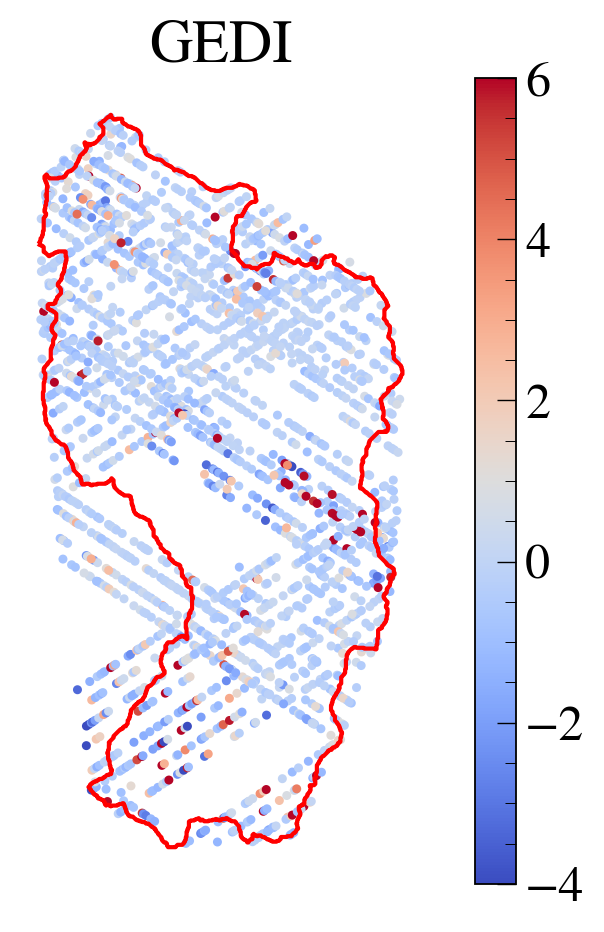

In [16]:
# Convert to GeoDataFrame
gedi_gdf = gpd.GeoDataFrame(
    gedi_resid_gdf,                         # DataFrame
    geometry=gpd.points_from_xy(
        gedi_resid_gdf["Easting_l2a"],
        gedi_resid_gdf["Northing_l2a"]
    ),
    crs="EPSG:6340"
)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

gedi_gdf.plot(
    column="resid_srf",
    cmap="coolwarm",
    legend=True, vmin=-4, vmax=6, #vmin=-2, vmax=4,
    markersize=5,     # increase point size
    ax=ax
)

# Shapefile overlay 
shapefile.boundary.plot(ax=ax, edgecolor="red", linewidth=1.5)

ax.set_title("GEDI")
ax.set_axis_off()

plt.tight_layout()
plt.show()


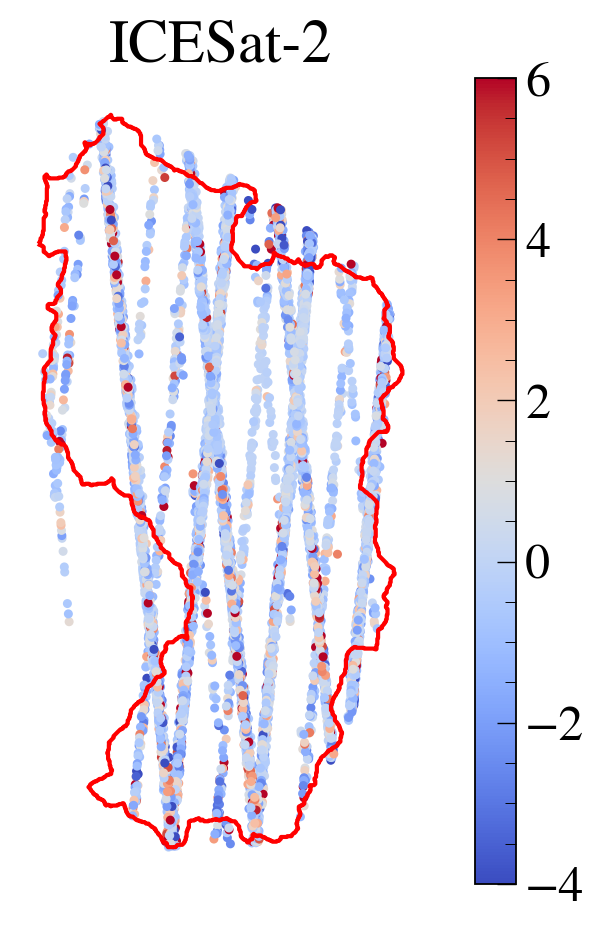

In [17]:
# Convert to GeoDataFrame
atl08_gdf = gpd.GeoDataFrame(
    atl08_resid_gdf,                         # DataFrame
    geometry=gpd.points_from_xy(
        atl08_resid_gdf["Easting"],
        atl08_resid_gdf["Northing"]
    ),
    crs="EPSG:6340"
)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

atl08_gdf.plot(
    column="resid_srf",
    cmap="coolwarm",
    legend=True, vmin=-4, vmax=6,
    markersize=5,
    ax=ax
)

# Shapefile overlay 
shapefile.boundary.plot(ax=ax, edgecolor="red", linewidth=1.5)

ax.set_title("ICESat-2")
ax.set_axis_off()

plt.tight_layout()
plt.show()


In [23]:
# df_all_gedi_filename = "/bsuhome/tnde/scratch/carbon_estimation/data/gedi_data/gedi_finder/ml_data/df_all_airborne_gedi.csv"
# df_all_icesat2_filename = Path("/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/ml_data/df_all_airborne_icesat2.csv")

# df_all_results_gedi = pd.read_csv(df_all_gedi_filename)
# df_all_results_icesat2 = pd.read_csv(df_all_icesat2_filename)

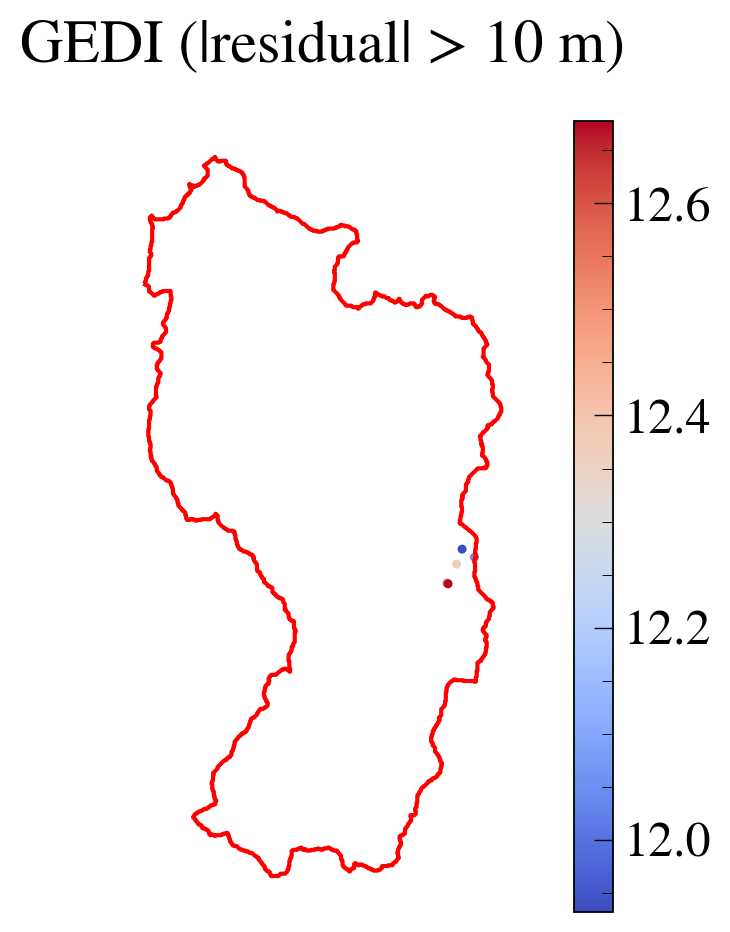

In [30]:
# Convert to GeoDataFrame
gedi_gdf = gpd.GeoDataFrame(
    gedi_resid_gdf,  # DataFrame
    geometry=gpd.points_from_xy(
        gedi_resid_gdf["Easting_l2a"],
        gedi_resid_gdf["Northing_l2a"]
    ),
    crs="EPSG:6340"
)

# Keep only errors larger than 10 in magnitude
gedi_gdf_big_err = gedi_gdf[gedi_gdf["resid_srf"].abs() > 11.5].copy()

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

gedi_gdf_big_err.plot(
    column="resid_srf",
    cmap="coolwarm",
    legend=True,  # vmin=-2, vmax=4,
    markersize=5,
    ax=ax
)

# Shapefile overlay 
shapefile.boundary.plot(ax=ax, edgecolor="red", linewidth=1.5)

ax.set_title("GEDI (|residual| > 10 m)")
ax.set_axis_off()

plt.tight_layout()
plt.show()


In [33]:
gedi_gdf_big_err = gedi_gdf_big_err.to_crs("EPSG:4326")
gedi_gdf_big_err["geometry"]

1791     POINT (-116.7072 43.17528)
1792    POINT (-116.70126 43.17242)
1808    POINT (-116.70982 43.17004)
1811     POINT (-116.7146 43.16347)
1812    POINT (-116.71396 43.16316)
Name: geometry, dtype: geometry

In [71]:
df_all_results_gedi[["slope_deg", "chm_mean"]]

slope_deg  chm_mean
0       1.186505  0.010010
1       3.351962  0.020020
2       2.127922  0.030029
3       2.731601  0.010010
4       4.448167  0.020020
...          ...       ...
64656   6.071718  0.029097
64657   5.864382  0.020125
64658   4.213081  0.020862
64659  10.355926  0.019549
64660   7.563278  0.019898

[64661 rows x 2 columns]

In [72]:
df_all_results_gedi[["slope_deg", "chm_mean"]]
# Count NaNs in each column
df_all_results_gedi[["slope_deg", "chm_mean"]].isna().sum()


slope_deg    0
chm_mean     0
dtype: int64

In [57]:
# Make GeoDataFrames with residuals
gedi_air_resid_gdf  = gediX.loc[df_air_gedi["src_idx"]].copy()
atl08_air_resid_gdf = atl08X.loc[df_air_atl8["src_idx"]].copy()

gedi_air_resid_gdf["resid_rf"]  = df_air_gedi["resid_rf"].values
gedi_air_resid_gdf["resid_srf"] = df_air_gedi["resid_srf"].values

atl08_air_resid_gdf["resid_rf"]  = df_air_atl8["resid_rf"].values
atl08_air_resid_gdf["resid_srf"] = df_air_atl8["resid_srf"].values


In [19]:
# # separate datasets
# atl08_air_resid_filename = "/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/ml_data/atl08_air_resid_gdf.csv"
# atl08_air_resid_gdf.to_csv(atl08_air_resid_filename, index=False)

# gedi_air_resid_filename = "/bsuhome/tnde/scratch/carbon_estimation/data/gedi_data/gedi_finder/ml_data/gedi_air_resid_gdf.csv"
# gedi_air_resid_gdf.to_csv(gedi_air_resid_filename, index=False)

atl08_air_resid_filename = "/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/ml_data/atl08_air_resid_gdf.csv"
gedi_air_resid_filename = "/bsuhome/tnde/scratch/carbon_estimation/data/gedi_data/gedi_finder/ml_data/gedi_air_resid_gdf.csv"

atl08_air_resid_gdf = pd.read_csv(atl08_air_resid_filename)
gedi_air_resid_gdf = pd.read_csv(gedi_air_resid_filename)

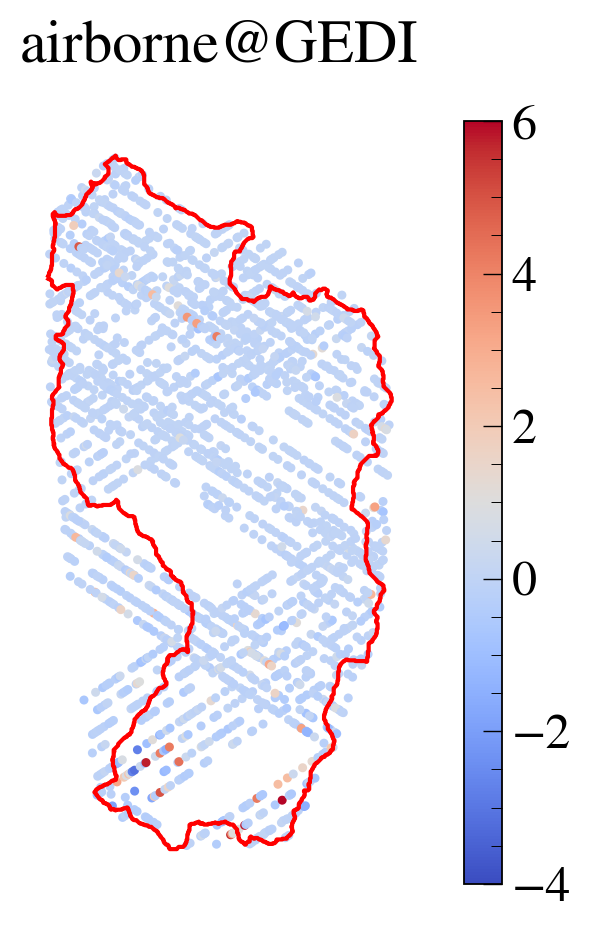

In [20]:
# Convert to GeoDataFrame
gedi_air_gdf = gpd.GeoDataFrame(
    gedi_air_resid_gdf,                         # your DataFrame
    geometry=gpd.points_from_xy(
        gedi_air_resid_gdf["Easting_l2a"],
        gedi_air_resid_gdf["Northing_l2a"]
    ),
    crs="EPSG:6340"
)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

gedi_air_gdf.plot(
    column="resid_srf",
    cmap="coolwarm",
    legend=True, vmin=-4, vmax=6,
    markersize=5,     # increase point size
    ax=ax
)

# Shapefile overlay 
shapefile.boundary.plot(ax=ax, edgecolor="red", linewidth=1.5)

ax.set_title("airborne@GEDI")
ax.set_axis_off()

plt.tight_layout()
plt.show()


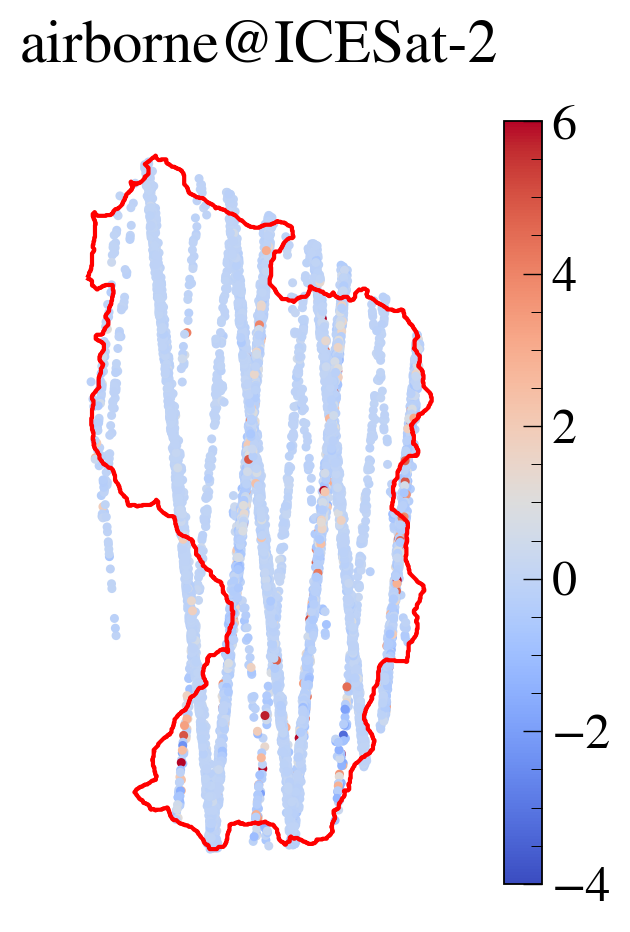

In [21]:
# Convert to GeoDataFrame
atl08_air_gdf = gpd.GeoDataFrame(
    atl08_air_resid_gdf,                         # your DataFrame
    geometry=gpd.points_from_xy(
        atl08_air_resid_gdf["Easting"],
        atl08_air_resid_gdf["Northing"]
    ),
    crs="EPSG:6340"
)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

atl08_air_gdf.plot(
    column="resid_srf",
    cmap="coolwarm",
    legend=True, vmin=-4, vmax=6,
    markersize=5,
    ax=ax
)

# Shapefile overlay 
shapefile.boundary.plot(ax=ax, edgecolor="red", linewidth=1.5)

ax.set_title("airborne@ICESat-2")
ax.set_axis_off()

plt.tight_layout()
plt.show()


### Overlay RCEW shape on ESRI world imagery

In [37]:
# -------------------------------
# Read shapefile
# -------------------------------
shp = "/bsuhome/tnde/geoscience/carbon_estimation/RCEW_shapefile_josh/RCEW_Boundary.shp"
shapefile = gpd.read_file(shp)

# Reproject to WGS84 (lat/lon) for web mapping if needed
if shapefile.crs is None:
    raise ValueError("Shapefile has no CRS; set shapefile.crs before reprojecting.")
if shapefile.crs.to_epsg() != 4326:
    shapefile = shapefile.to_crs(epsg=4326)

# Get a reasonable center for the map (using the shapefile centroid)
centroid = shapefile.geometry.unary_union.centroid
center_lat, center_lon = centroid.y, centroid.x

# -------------------------------
# Create folium map with Esri World Imagery
# -------------------------------
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=12,
    tiles=None  # we'll add Esri imagery manually
)

# Esri World Imagery basemap
folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/"
          "World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri World Imagery",
    name="Esri World Imagery",
    overlay=False,
    control=True,
).add_to(m)

# Overlay the shapefile
folium.GeoJson(
    shapefile,
    name="RCEW Boundary",
    style_function=lambda feature: {
        "color": "red",
        "weight": 5,
        "fill": False,
    },
).add_to(m)

# Layer control (toggle layers on/off)
folium.LayerControl().add_to(m)

# -------------------------------
# Save to HTML
# -------------------------------
out_html = "rcew_boundary_esri_world_imagery_no_fill.html"
m.save(out_html)
print(f"Saved interactive map to {out_html}")

Saved interactive map to rcew_boundary_esri_world_imagery_no_fill.html


/tmp/ipykernel_195418/745984556.py:17: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = shapefile.geometry.unary_union.centroid
